In [1]:
import math
import time
from multiprocessing import Pool
from copy import deepcopy
import dill as pickle
import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import torch
from matplotlib import ticker
from pyloric import create_prior, simulate, summary_stats
from pyloric.utils import show_traces
from pyloric.utils import energy_of_membrane, energy_of_synapse
from stg_energy import check_if_close_to_obs 
from sbi.analysis import ActiveSubspace
from sbi.utils import BoxUniform
from stg_energy.common import get_labels_8pt
from sbi.analysis import pairplot
from pyloric import create_prior

import stg_energy.fig3_active_subspaces.viz as viz
from stg_energy.fig3_active_subspaces.helper_functions import nth_argmax, nth_argmin

# Figure 3

In [2]:
pd.options.display.max_columns = 999

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
PANEL_A = "../svg/panel_a.svg"
PANEL_B = "../svg/panel_b.svg"
PANEL_B_raw = "../svg/panel_b_raw.svg"
PANEL_C = "../svg/panel_c.svg"
PANEL_D = "../svg/panel_d.svg"
PANEL_E1 = "../svg/panel_e1.svg"
PANEL_E2 = "../svg/panel_e2.svg"
PANEL_F1 = "../svg/panel_f1.svg"
PANEL_F1_raw = "../svg/panel_f1_raw.svg"
PANEL_F2 = "../svg/panel_f2.svg"
PANEL_G1 = "../svg/panel_g1.svg"
PANEL_G2 = "../svg/panel_g2.svg"
PANEL_H1 = "../svg/panel_h1.svg"
PANEL_H2 = "../svg/panel_h2.svg"
PANEL_I1 = "../svg/panel_i1.svg"
PANEL_I2 = "../svg/panel_i2.svg"

PANEL_supp_EV1 = "../svg/panel_supp_ev1.svg"
PANEL_supp_EV2 = "../svg/panel_supp_ev2.svg"
PANEL_supp_EV3 = "../svg/panel_supp_ev3.svg"

PANEL_supp_shift1 = "../svg/panel_supp_shift1.svg"
PANEL_supp_shift2 = "../svg/panel_supp_shift2.svg"
PANEL_supp_shift3 = "../svg/panel_supp_shift3.svg"
PANEL_supp_shift4 = "../svg/panel_supp_shift4.svg"
PANEL_supp_shift5 = "../svg/panel_supp_shift5.svg"
PANEL_supp_shift6 = "../svg/panel_supp_shift6.svg"

PANEL_supp_performance1 = "../svg/panel_supp_performance1.svg"
PANEL_supp_performance2 = "../svg/panel_supp_performance2.svg"
PANEL_supp_performance3 = "../svg/panel_supp_performance3.svg"

PANEL_supp_synapses1 = "../svg/panel_supp_synapses1.svg"
PANEL_supp_synapses2 = "../svg/panel_supp_synapses2.svg"
PANEL_supp_synapses3 = "../svg/panel_supp_synapses3.svg"

### Load experimental data

In [5]:
prior_11 = create_prior()

In [6]:
theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl"
)
x = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl"
)
seeds = np.load(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy"
)

theta_np = theta.to_numpy()
x_np = x.to_numpy()

In [7]:
import sys
sys.path.append("home/michael/Documents/sbi/sbi/utils/user_input_checks_utils")

In [8]:
import sys
from sbi.utils import user_input_checks_utils

sys.modules["sbi.user_input.user_input_checks_utils"] = user_input_checks_utils

In [9]:
with open(
    "../../../results/trained_neural_nets/inference/posterior_11deg.pickle", "rb"
) as handle:
    posterior = pickle.load(handle)
    posterior._device = 'cpu'

/home/michael/Documents/sbi/sbi/inference/posteriors/base_posterior.py:1117: UserWarning: You had saved the posterior under an older version of `sbi`. To make the loaded version comply with the version you are using right now, we had to set the following attributes: `self._device = cpu` `self._num_iid_trials = None` `self._iid_methods = ['snle', 'snre_a', 'snre_b']` `self._allow_iid_x = False`
  warn(warning_description + warning_msg)


In [10]:
posterior._prior = BoxUniform(posterior._prior.support.base_constraint.lower_bound, posterior._prior.support.base_constraint.upper_bound)

In [11]:
xo = np.load("../../../results/experimental_data/xo_11deg.npy")

In [12]:
energies = x["energies"]

In [13]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

In [14]:
summed_energies = np.sum(x['energies'].to_numpy(), axis=1) / 10 / 1000

In [15]:
inds = np.argsort(summed_energies)

In [16]:
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
quantile = 0.02
one_percent_quantile = int(num_vals * quantile)
ninenine_percent_quantile = int(num_vals * (1-quantile))
one_percent_energy = sorted_energies[one_percent_quantile]
ninenine_percent_energy = sorted_energies[ninenine_percent_quantile]

In [17]:
min_energy_condition = summed_energies < one_percent_energy
max_energy_condition = summed_energies > ninenine_percent_energy

In [18]:
min_energy_theta = theta_np[min_energy_condition]
max_energy_theta = theta_np[max_energy_condition]

min_energy_energies = summed_energies[min_energy_condition]
max_energy_energies = summed_energies[max_energy_condition]

In [19]:
prior = create_prior(as_torch_dist=True)
lower_b = prior.support.base_constraint.lower_bound.unsqueeze(0)
upper_b = prior.support.base_constraint.upper_bound.unsqueeze(0)
limits = torch.cat((lower_b, upper_b), dim=0).T

# Plot 31 posterior with constraints on total energy consumption

In [20]:
labels_ = get_labels_8pt()

In [21]:
lims=limits.numpy()

In [22]:
from decimal import Decimal
all_labels = []
for dim_i in range(31):
    if dim_i > 31 - 7.5: # synapses
        if dim_i == 24: all_labels.append([r'$\mathdefault{0.01}\;\;\;\;\;\;\;$         ', r'$\mathdefault{10000}\;\;\;\;\;\;$    '])
        else: all_labels.append([r'$\;\;\mathdefault{0.01}\;\;\;\;\;$       ', r'$\mathdefault{1000}\;\;\;\;\;$  '])
    else: # membrane conductances
        num_after_digits = -int(np.log10(lims[dim_i, 1]))
        if num_after_digits > 2:
            num_after_digits=2
        labels = [round((lims[dim_i, num_tmp]), num_after_digits) if lims[dim_i, num_tmp] < 1.0 else int(lims[dim_i, num_tmp])
                  for num_tmp in range(2)]
        new_labels = []
        counter=0
        for l in labels:
            if counter == 0:
                new_labels.append(r'$\mathdefault{'+str(l)+'}\;\;\;$      ')
            else:
                new_labels.append(r'$\mathdefault{'+str(l)+'}\;\;\;$   ')
            counter+=1
        all_labels.append(new_labels)

KeyboardInterrupt: 

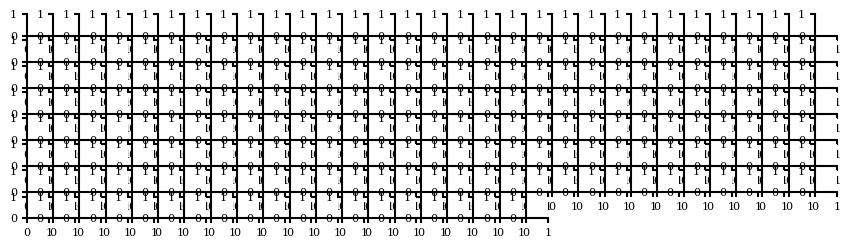

In [25]:
import matplotlib.patheffects as pe

with mpl.rc_context(fname='../../../.matplotlibrc'):

    labels_ = get_labels_8pt()
    new_labels = []
    for l in labels_:
        new_labels.append(l+'    '+r'$\;\;$')
    labels_ = new_labels
    labels_[9] += ''

    fig, axes = pairplot(
        samples=min_energy_theta,
        subset=[0,1,2,4],
        labelpad=1,
        tick_labelpad=1,
        limits=limits,
        ticks=limits,
        tick_labels=all_labels,
        figsize=(10.45, 10.45),
        labels=labels_,
        scatter_offdiag={'rasterized':True, 'alpha':1.0},
        diag=['kde'],
        upper=['kde'],
        hist_offdiag={'bins':50},
        plot_offdiag={'linewidth': 1.6, 'path_effects':[pe.Stroke(linewidth=2.4, foreground='k'), pe.Normal()]}
    )

### Repeat same analysis for AB/PD neuron

In [23]:
quantile = 0.0002

In [24]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

summed_energies = x['energies'].to_numpy()[:, 0] / 10 / 1000

In [25]:
inds = np.argsort(summed_energies)
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
one_percent_quantile = int(num_vals * quantile)
ninenine_percent_quantile = int(num_vals * (1-quantile))
one_percent_energy = sorted_energies[one_percent_quantile]
ninenine_percent_energy = sorted_energies[ninenine_percent_quantile]

min_energy_condition = summed_energies < one_percent_energy
max_energy_condition = summed_energies > ninenine_percent_energy

min_energy_theta = theta_np[min_energy_condition]
max_energy_theta = theta_np[max_energy_condition]

min_energy_energies = summed_energies[min_energy_condition]
max_energy_energies = summed_energies[max_energy_condition]

min_energy_theta = theta_np[min_energy_condition]
max_energy_theta = theta_np[max_energy_condition]

min_energy_energies = summed_energies[min_energy_condition]
max_energy_energies = summed_energies[max_energy_condition]

In [ ]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.4, 1.0))
    vals, xvals = np.histogram(summed_energies, bins=100, range=[0, 30])
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, c='k')
    _ = ax.hist(min_energy_energies, bins=100, range=[0, 30], color='#fd8d3c')
    _ = ax.hist(max_energy_energies, bins=100, range=[0, 30], color='#bd0026')
    ax.set_xlabel("Energy ($\mu$J/s)")
    ax.set_ylabel("Count")
    ax.set_xlim([0, 10])
    ax.set_xticks([0, 10])

In [ ]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.4, 1.0))
    vals, xvals = np.histogram(summed_energies, bins=30, range=[0, 0.5])
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, c='k')
    _ = ax.hist(min_energy_energies, bins=30, range=[0, 0.5], color='#fd8d3c')
    _ = ax.hist(max_energy_energies, bins=30, range=[0, 0.5], color='#bd0026')
    ax.set_xlabel("Energy ($\mu$J/s)")
    ax.set_ylabel("Count")
    ax.set_xlim([0,0.5])
    ax.set_xticks([0, 0.5])

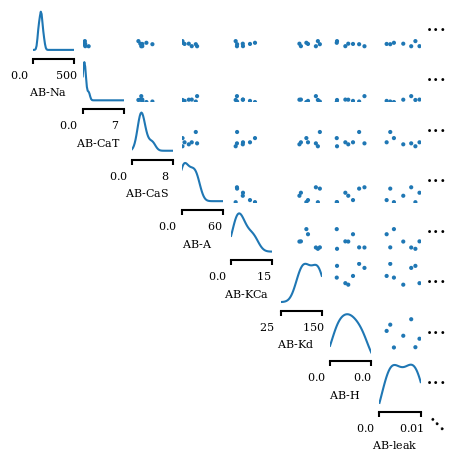

In [136]:
import matplotlib.patheffects as pe

with mpl.rc_context(fname='../../../.matplotlibrc'):

    labels_ = get_labels_8pt()
    new_labels = []
    for l in labels_:
        new_labels.append(l+'    '+r'$\;\;$')
    labels_ = new_labels
    labels_[9] += ''

    fig, axes = pairplot(
        samples=min_energy_theta,
        subset=[0,1,2,3,4,5,6,7],
        labelpad=1,
        tick_labelpad=1,
        limits=limits,
        ticks=limits,
        tick_labels=all_labels,
        figsize=(5, 5),
        labels=labels_,
        scatter_offdiag={'rasterized':True, 'alpha':1.0},
        diag=['kde'],
        upper=['scatter'],
        hist_offdiag={'bins':50},
        plot_offdiag={'linewidth': 1.6, 'path_effects':[pe.Stroke(linewidth=2.4, foreground='k'), pe.Normal()]}
    )

### Same for LP

In [26]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

summed_energies = x['energies'].to_numpy()[:, 1] / 10 / 1000

In [27]:
inds = np.argsort(summed_energies)
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
one_percent_quantile = int(num_vals * quantile)
ninenine_percent_quantile = int(num_vals * (1-quantile))
one_percent_energy = sorted_energies[one_percent_quantile]
ninenine_percent_energy = sorted_energies[ninenine_percent_quantile]

min_energy_condition = summed_energies < one_percent_energy
max_energy_condition = summed_energies > ninenine_percent_energy

min_energy_theta = theta_np[min_energy_condition]
max_energy_theta = theta_np[max_energy_condition]

min_energy_energies = summed_energies[min_energy_condition]
max_energy_energies = summed_energies[max_energy_condition]

min_energy_theta = theta_np[min_energy_condition]
max_energy_theta = theta_np[max_energy_condition]

min_energy_energies = summed_energies[min_energy_condition]
max_energy_energies = summed_energies[max_energy_condition]

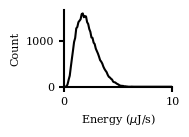

In [139]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.4, 1.0))
    vals, xvals = np.histogram(summed_energies, bins=100, range=[0, 10])
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, c='k')
    _ = ax.hist(min_energy_energies, bins=100, range=[0, 10], color='#fd8d3c')
    _ = ax.hist(max_energy_energies, bins=100, range=[0, 10], color='#bd0026')
    ax.set_xlabel("Energy ($\mu$J/s)")
    ax.set_ylabel("Count")
    ax.set_xlim([0, 10])
    ax.set_xticks([0, 10])

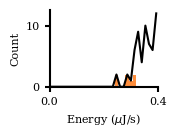

In [142]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.4, 1.0))
    vals, xvals = np.histogram(summed_energies, bins=30, range=[0, 0.4])
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, c='k')
    _ = ax.hist(min_energy_energies, bins=30, range=[0, 0.4], color='#fd8d3c')
    _ = ax.hist(max_energy_energies, bins=30, range=[0, 0.4], color='#bd0026')
    ax.set_xlabel("Energy ($\mu$J/s)")
    ax.set_ylabel("Count")
    ax.set_xlim([0, 0.4])
    ax.set_xticks([0, 0.4])

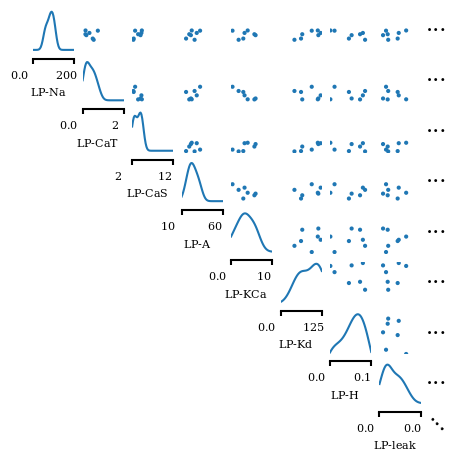

In [28]:
import matplotlib.patheffects as pe

with mpl.rc_context(fname='../../../.matplotlibrc'):

    labels_ = get_labels_8pt()
    new_labels = []
    for l in labels_:
        new_labels.append(l+'    '+r'$\;\;$')
    labels_ = new_labels
    labels_[9] += ''

    fig, axes = pairplot(
        samples=min_energy_theta,
        subset=[8,9,10,11,12,13,14,15],
        labelpad=1,
        tick_labelpad=1,
        limits=limits,
        ticks=limits,
        tick_labels=all_labels,
        figsize=(5, 5),
        labels=labels_,
        scatter_offdiag={'rasterized':True, 'alpha':1.0},
        diag=['kde'],
        upper=['scatter'],
        hist_offdiag={'bins':50},
        plot_offdiag={'linewidth': 1.6, 'path_effects':[pe.Stroke(linewidth=2.4, foreground='k'), pe.Normal()]}
    )

### Same for PY

In [29]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

summed_energies = x['energies'].to_numpy()[:, 2] / 10 / 1000

In [30]:
inds = np.argsort(summed_energies)
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
one_percent_quantile = int(num_vals * quantile)
ninenine_percent_quantile = int(num_vals * (1-quantile))
one_percent_energy = sorted_energies[one_percent_quantile]
ninenine_percent_energy = sorted_energies[ninenine_percent_quantile]

min_energy_condition = summed_energies < one_percent_energy
max_energy_condition = summed_energies > ninenine_percent_energy

min_energy_theta = theta_np[min_energy_condition]
max_energy_theta = theta_np[max_energy_condition]

min_energy_energies = summed_energies[min_energy_condition]
max_energy_energies = summed_energies[max_energy_condition]

min_energy_theta = theta_np[min_energy_condition]
max_energy_theta = theta_np[max_energy_condition]

min_energy_energies = summed_energies[min_energy_condition]
max_energy_energies = summed_energies[max_energy_condition]

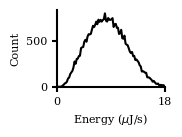

In [156]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.4, 1.0))
    vals, xvals = np.histogram(summed_energies, bins=100, range=[0, 18])
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, c='k')
    _ = ax.hist(min_energy_energies, bins=100, range=[0, 18], color='#fd8d3c')
    _ = ax.hist(max_energy_energies, bins=100, range=[0, 18], color='#bd0026')
    ax.set_xlabel("Energy ($\mu$J/s)")
    ax.set_ylabel("Count")
    ax.set_xlim([0, 18])
    ax.set_xticks([0, 18])

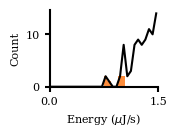

In [157]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.4, 1.0))
    vals, xvals = np.histogram(summed_energies, bins=30, range=[0, 1.5])
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, c='k')
    _ = ax.hist(min_energy_energies, bins=30, range=[0, 1.5], color='#fd8d3c')
    _ = ax.hist(max_energy_energies, bins=30, range=[0, 1.5], color='#bd0026')
    ax.set_xlabel("Energy ($\mu$J/s)")
    ax.set_ylabel("Count")
    ax.set_xlim([0, 1.5])
    ax.set_xticks([0, 1.5])

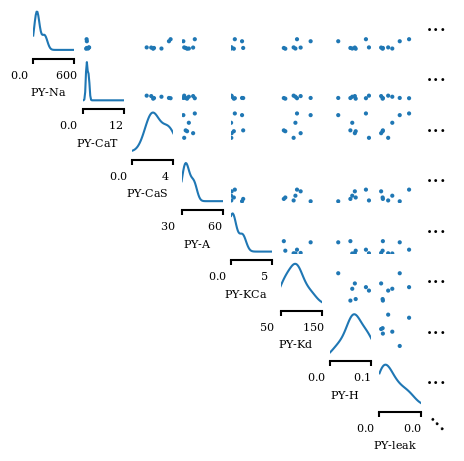

In [159]:
import matplotlib.patheffects as pe

with mpl.rc_context(fname='../../../.matplotlibrc'):

    labels_ = get_labels_8pt()
    new_labels = []
    for l in labels_:
        new_labels.append(l+'    '+r'$\;\;$')
    labels_ = new_labels
    labels_[9] += ''

    fig, axes = pairplot(
        samples=min_energy_theta,
        subset=[16,17,18,19,20,21,22,23],
        labelpad=1,
        tick_labelpad=1,
        limits=limits,
        ticks=limits,
        tick_labels=all_labels,
        figsize=(5, 5),
        labels=labels_,
        scatter_offdiag={'rasterized':True, 'alpha':1.0},
        diag=['kde'],
        upper=['scatter'],
        hist_offdiag={'bins':50},
        plot_offdiag={'linewidth': 1.6, 'path_effects':[pe.Stroke(linewidth=2.4, foreground='k'), pe.Normal()]}
    )

### Cluster together the best neuron and sample the conditional posterior

In [31]:
summed_energies = x['energies'].to_numpy()[:, 0] / 10 / 1000
min_ind = np.argmin(summed_energies)
min_energy_theta_ABPD = theta_np[min_ind]

summed_energies = x['energies'].to_numpy()[:, 1] / 10 / 1000
min_ind = np.argmin(summed_energies)
min_energy_theta_LP = theta_np[min_ind]

summed_energies = x['energies'].to_numpy()[:, 2] / 10 / 1000
min_ind = np.argmin(summed_energies)
min_energy_theta_PY = theta_np[min_ind]

In [32]:
optimal_ = min_energy_theta_ABPD
optimal_[8:16] = min_energy_theta_LP[8:16]
optimal_[16:24] = min_energy_theta_PY[16:24]

In [32]:
optimal_ = torch.as_tensor(optimal_, dtype=torch.float32)

In [28]:
samples = posterior.sample_conditional(
    (1000,), 
    condition=torch.as_tensor(optimal_, dtype=torch.float32),
    dims_to_sample=[24,25,26,27,28,29,30], 
    x=xo,
    mcmc_method="slice_np",
    mcmc_parameters={"init_strategy": "sir"},
)

Generating samples: 100%|██████████| 1000/1000 [1:27:58<00:00,  5.28s/it]


In [29]:
# np.save("mcmc_7d_optimal_samples.npy", samples.numpy())

In [30]:
sss = np.load("mcmc_7d_optimal_samples.npy")

In [32]:
samples_ = deepcopy(samples)

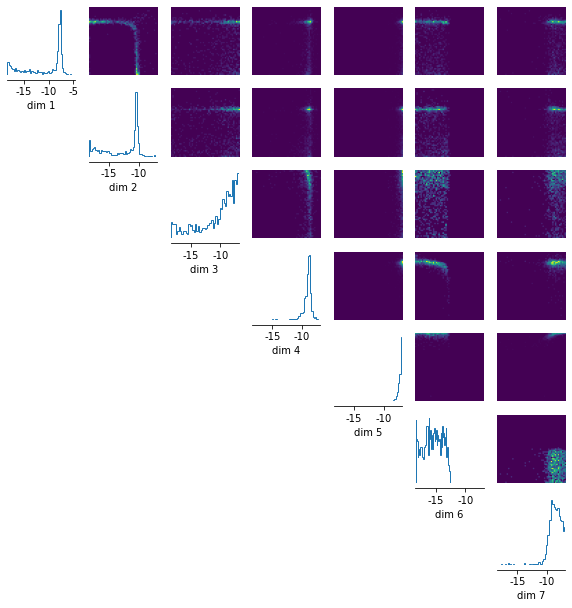

In [33]:
_ = pairplot(samples_, limits=limits[24:])

### Simulate these samples

In [33]:
theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl"
)

In [34]:
def simulator(p_with_s):
    circuit_params = np.asarray([p_with_s[:-1]])
    theta_pd = pd.DataFrame(circuit_params, columns=theta.columns)
    out_target = simulate(
        theta_pd.loc[0], seed=int(p_with_s[-1]), track_energy=True, track_currents=True
    )
    return out_target

In [35]:
from multiprocessing import Pool

In [66]:
np.random.seed(0)
num_cores = 24
num_sims = 100
seeds_sim = np.random.randint(0, 10000, num_sims)

extended_samples = optimal_.unsqueeze(0).repeat(1000, 1)
extended_samples[:, [24,25,26,27,28,29,30]] = samples_

params_with_seeds = np.concatenate(
    (
        extended_samples.numpy()[:num_sims],
        seeds_sim[None,].T,
    ),
    axis=1,
)

with Pool(num_cores) as pool:
    data = pool.map(simulator, params_with_seeds)
    
custom_stats = {
        "plateau_durations": True,
        "num_bursts": True,
        "num_spikes": True,
        "energies": True,
        "energies_per_burst": True,
        "energies_per_spike": True,
        "pyloric_like": True,
    }
stats = [summary_stats(d, stats_customization=custom_stats, t_burn_in=1000) for d in data]
stats = pd.concat(stats)

close_sim = check_if_close_to_obs(stats.to_numpy())

for s, d in zip(stats.to_numpy(), data):
    print(s[:18])
    show_traces(d)
    plt.show()

In [79]:
close_sim

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [80]:
print("Number of accepted: ", np.sum(close_sim))

Number of accepted:  0


In [81]:
from pyloric.utils import show_traces

In [ ]:
good_ones = data[close_sim]

[1.50262000e+03 1.75620833e+02 1.63975000e+02 3.17028571e+02
 1.16876411e-01 1.09126060e-01 2.10983862e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


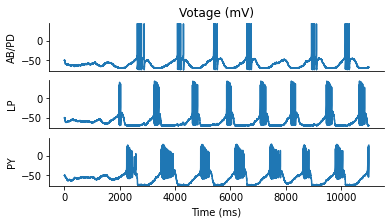

[1.66776667e+03 1.07293750e+02            nan            nan
 6.43337897e-02            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
            nan            nan]


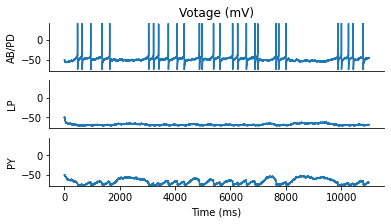

[2.54372500e+03 2.14858333e+02 1.87203571e+02 3.33264286e+02
 8.44660226e-02 7.35942649e-02 1.31014275e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


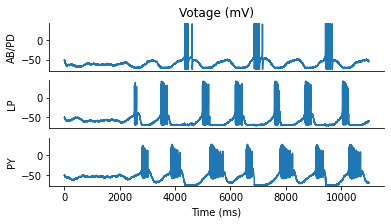

[2.04414375e+03 2.31400000e+02 1.62510000e+02 3.57000000e+02
 1.13201432e-01 7.95002798e-02 1.74645252e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


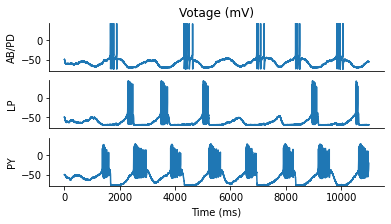

[1.51615417e+03 1.95717857e+02 7.09750000e+01 3.09993750e+02
 1.29088361e-01 4.68125218e-02 2.04460573e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


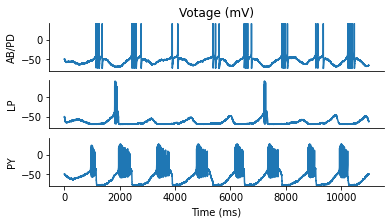

[2.02082500e+03 2.40985000e+02 1.96000000e+02 2.93487500e+02
 1.19250801e-01 9.69900907e-02 1.45231527e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


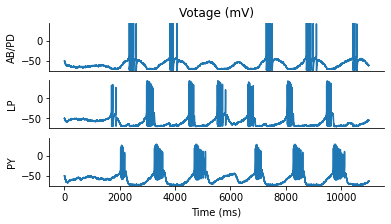

[1.65622000e+03 1.77866667e+02 1.32195833e+02 2.63403571e+02
 1.07393140e-01 7.98177980e-02 1.59038999e-01 5.65033631e-01
 6.71683110e-01 9.35820000e+02 1.76635000e+02 7.55930000e+02
 4.88850000e+01 4.56418833e-01 2.95160063e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


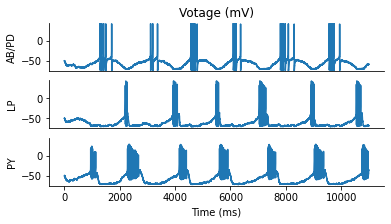

[1.29078750e+03 1.92146429e+02 1.57312500e+02 3.63300000e+02
 1.48859846e-01 1.21873275e-01 2.81456088e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


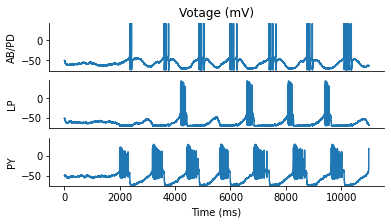

[1.49215000e+03 2.56189286e+02 1.13750000e+02 4.11539286e+02
 1.71691375e-01 7.62322823e-02 2.75802892e-01 5.32687732e-01
 6.21530454e-01 7.94850000e+02 1.32566667e+02 5.26137500e+02
 1.88166667e+01 3.52603626e-01 1.26104391e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


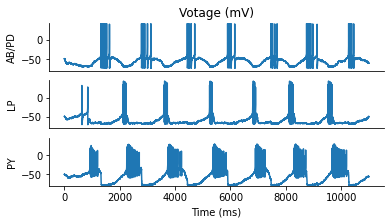

[1.53756500e+03 2.55875000e+02 1.15033333e+02 3.57682143e+02
 1.66415729e-01 7.48152653e-02 2.32628957e-01 5.72005086e-01
 6.66144196e-01 8.79495000e+02 1.44745000e+02 6.41650000e+02
 2.35500000e+01 4.17315691e-01 1.53164256e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


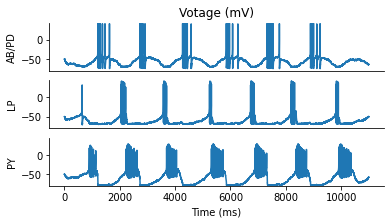

[1.44305000e+03 1.83321429e+02 1.06312500e+02 4.12058333e+02
 1.27037475e-01 7.36720834e-02 2.85546816e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


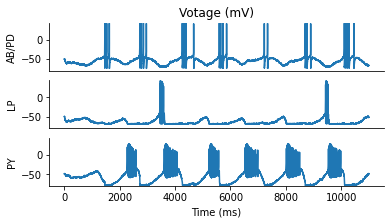

[1.43832500e+03 1.30583333e+02 1.05700000e+02 2.59441667e+02
 9.07884750e-02 7.34882589e-02 1.80377638e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


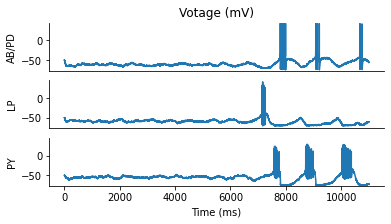

[1.30181250e+03 1.92233333e+02 1.28945000e+02 3.78250000e+02
 1.47665915e-01 9.90503625e-02 2.90556436e-01 4.56776610e-01
 6.46732920e-01 5.94637500e+02 2.47287500e+02 3.86637500e+02
 9.40125000e+01 2.96999376e-01 7.22166211e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


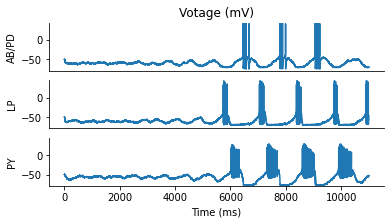

[2.17855000e+03 2.46508333e+02 2.23600000e+02 2.25621875e+02
 1.13152479e-01 1.02637075e-01 1.03565158e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


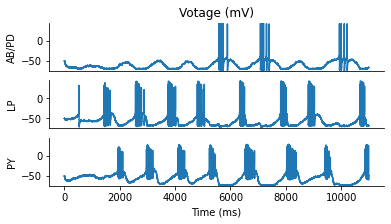

[2.88895000e+03 2.24766667e+02 1.59539286e+02 2.30575000e+02
 7.78022003e-02 5.52239692e-02 7.98127347e-02            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


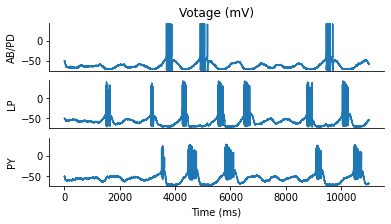

[1.93818750e+03 2.87450000e+02 1.09343750e+02 2.56375000e+02
 1.48308665e-01 5.64154655e-02 1.32275644e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


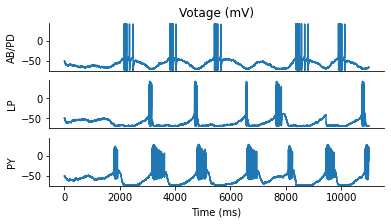

[         nan          nan 279.59722222 223.9                 nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan   2.5          2.5       ]


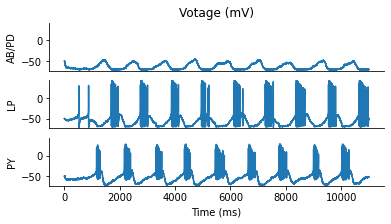

[6.49167500e+03 1.69400000e+02 2.11196875e+02 2.22821429e+02
 2.60949601e-02 3.25334948e-02 3.43241811e-02            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


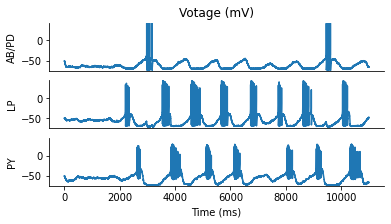

[1.37209167e+03 2.18003571e+02 1.70889286e+02 3.83575000e+02
 1.58884116e-01 1.24546552e-01 2.79554937e-01 4.17798859e-01
 6.05444243e-01 5.73258333e+02 2.57466667e+02 3.56562500e+02
 8.51083333e+01 2.59867842e-01 6.20281687e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


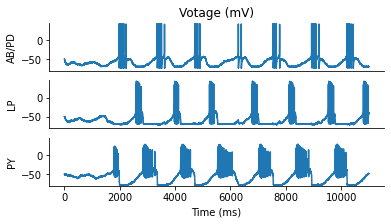

[2.65225000e+03 2.99300000e+02 2.47889286e+02 3.09664286e+02
 1.12847582e-01 9.34637707e-02 1.16755316e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


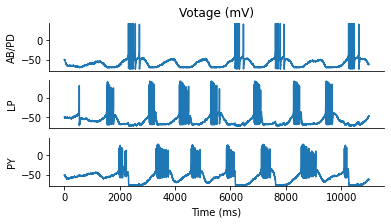

[1.11778214e+03 1.37525000e+02            nan            nan
 1.23033814e-01            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
            nan            nan]


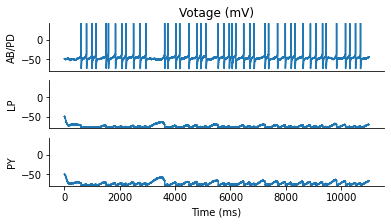

[1.76728000e+03 2.04225000e+02 1.68125000e+02 3.63462500e+02
 1.15558938e-01 9.51320674e-02 2.05662091e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


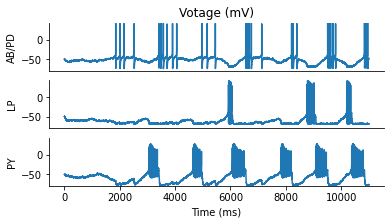

[2.53470833e+03 2.55831250e+02 2.15546875e+02 2.60371875e+02
 1.00931238e-01 8.50381372e-02 1.02722618e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


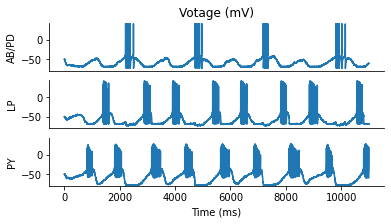

[1.51325000e+03 1.71167857e+02 1.94639286e+02 3.64756250e+02
 1.13112742e-01 1.28623351e-01 2.41041632e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


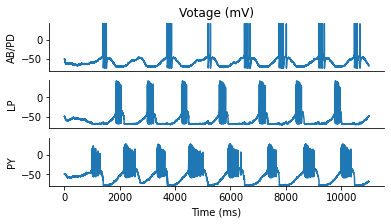

[1.91953750e+03 2.20683333e+02 1.79395833e+02 2.55385000e+02
 1.14966930e-01 9.34578425e-02 1.33045069e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


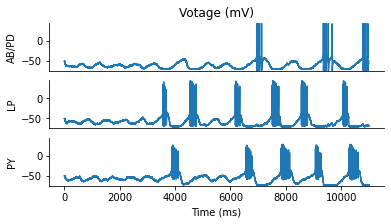

[1.41408000e+03 1.93808333e+02 2.00442857e+02 3.77434375e+02
 1.37056131e-01 1.41747891e-01 2.66911614e-01 4.46113374e-01
 6.18914771e-01 6.30840000e+02 2.44355000e+02 4.32940000e+02
 5.05900000e+01 3.06163725e-01 3.57759108e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


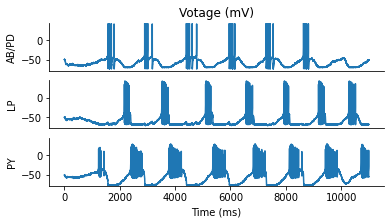

[7.23950000e+03 3.10325000e+02 2.49318750e+02 2.79484375e+02
 4.28655294e-02 3.44386698e-02 3.86054804e-02            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


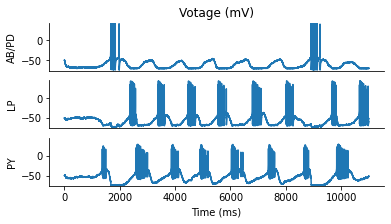

[1.74324000e+03 1.91537500e+02 1.54745000e+02 3.41265625e+02
 1.09874429e-01 8.87686148e-02 1.95765141e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


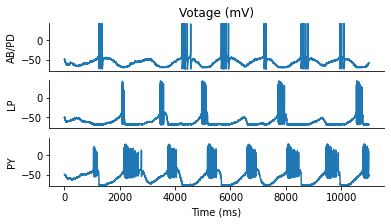

[1.76077500e+03 1.54785000e+02 1.47275000e+02 4.01650000e+02
 8.79073135e-02 8.36421462e-02 2.28109781e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


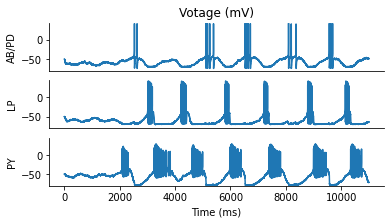

[7.34220000e+03 2.13700000e+02 2.38621875e+02 2.38480556e+02
 2.91057176e-02 3.25000511e-02 3.24808035e-02            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


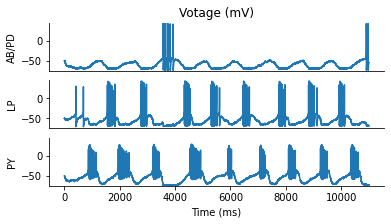

[1.44669000e+03 1.71658333e+02 9.22000000e+01 3.99745833e+02
 1.18655920e-01 6.37316910e-02 2.76317548e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


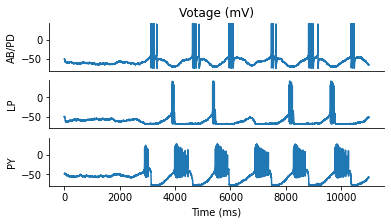

[1.44369500e+03 2.56970833e+02 9.05833333e+01 4.07825000e+02
 1.77995237e-01 6.27440930e-02 2.82486952e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


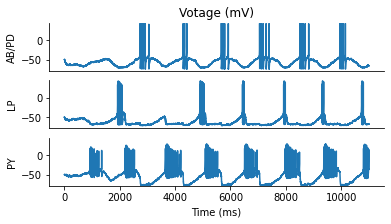

[3.25785000e+03 8.31250000e+01            nan 2.24875000e+02
 2.55152938e-02            nan 6.90255844e-02            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
            nan 2.50000000e+00]


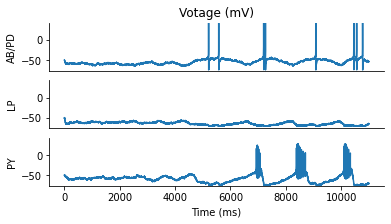

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


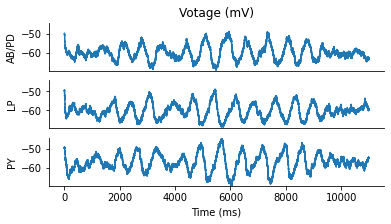

[2.24232500e+03 1.73500000e+02 2.39875000e+02 2.00766667e+02
 7.73750460e-02 1.06976018e-01 8.95350436e-02            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


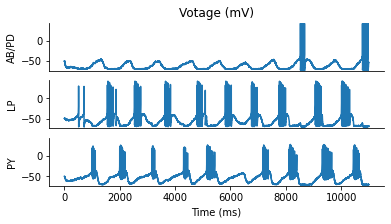

[   nan 129.85 191.75 234.05    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan   2.5    2.5    2.5 ]


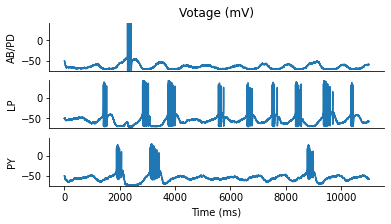

[2.28260000e+03 2.70025000e+02 2.65654167e+02 4.21216667e+02
 1.18297117e-01 1.16382269e-01 1.84533719e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


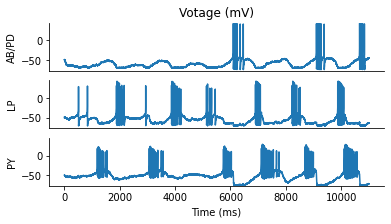

[1.73456250e+03 2.00820000e+02 2.09110714e+02 3.50332143e+02
 1.15775592e-01 1.20555307e-01 2.01971473e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


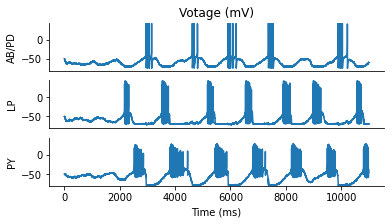

[1.62517500e+03 2.08637500e+02 1.91025000e+02 3.24217857e+02
 1.28378482e-01 1.17541188e-01 1.99497197e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


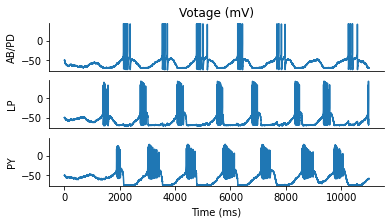

[1.57275417e+03 2.02053571e+02 1.23435000e+02 4.28404167e+02
 1.28471172e-01 7.84833400e-02 2.72391055e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


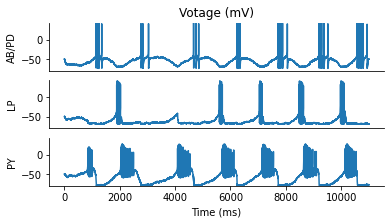

[3.23856667e+03 1.83906250e+02 2.10039286e+02 3.11189286e+02
 5.67863098e-02 6.48556313e-02 9.60885842e-02            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


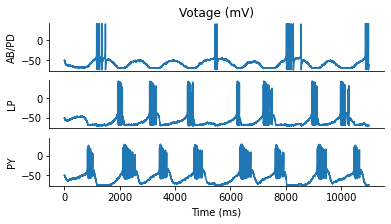

[1.53333333e+03 1.90096429e+02 1.64416667e+02 4.01925000e+02
 1.23975932e-01 1.07228261e-01 2.62125000e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


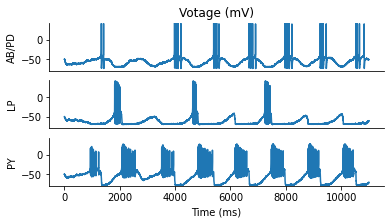

[1.57589500e+03 1.53025000e+02            nan 3.18775000e+02
 9.71035507e-02            nan 2.02281878e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
            nan 2.50000000e+00]


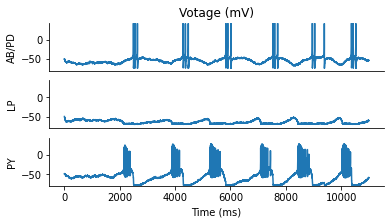

[1.52707500e+03 1.11645000e+02            nan 3.37231250e+02
 7.31103580e-02            nan 2.20834766e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
            nan 2.50000000e+00]


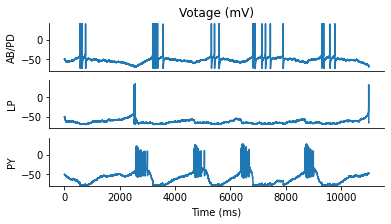

[         nan          nan 230.60277778 184.57777778          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan   2.5          2.5       ]


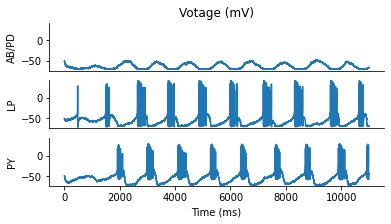

[2.75835000e+03 2.06800000e+02 1.78478125e+02 2.42783333e+02
 7.49723567e-02 6.47046695e-02 8.80175951e-02            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


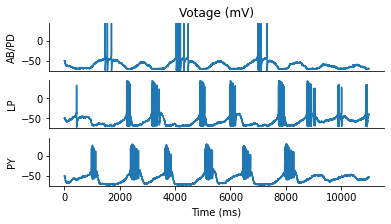

[1.75858125e+03 2.52590000e+02 1.40825000e+02 3.34066667e+02
 1.43632829e-01 8.00787567e-02 1.89963737e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


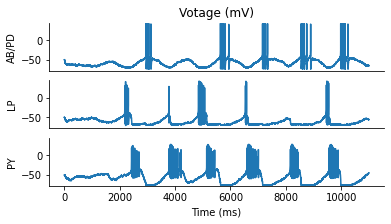

[1.49279000e+03 2.59029167e+02 1.49475000e+02 3.75078571e+02
 1.73520165e-01 1.00131298e-01 2.51260105e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


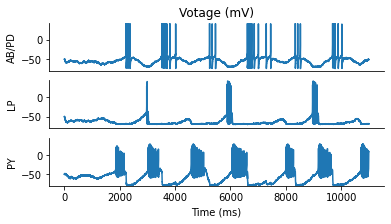

[1.70526250e+03 2.37315000e+02 1.73021429e+02 3.09389286e+02
 1.39166257e-01 1.01463223e-01 1.81432059e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


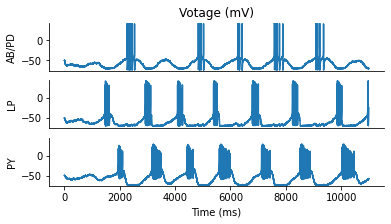

[1.89059167e+03 1.75987500e+02 1.35318750e+02 4.22933333e+02
 9.30859387e-02 7.15748156e-02 2.23704220e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


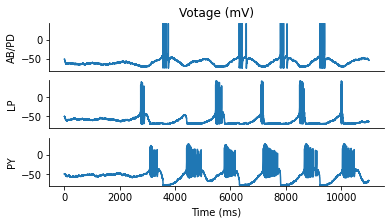

[1.93487500e+03 1.94715000e+02 1.67367857e+02 3.06000000e+02
 1.00634408e-01 8.65006045e-02 1.58149751e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


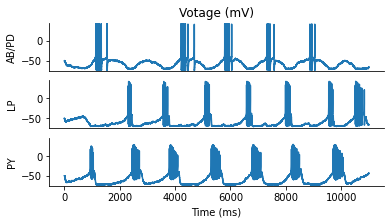

[2.37133750e+03 1.86770000e+02 2.15637500e+02 3.53910714e+02
 7.87614585e-02 9.09349681e-02 1.49245189e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


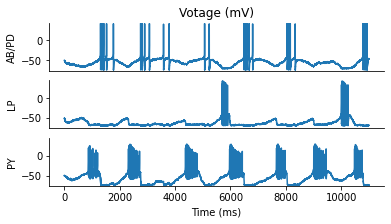

[1.61448000e+03 1.34645833e+02 1.56666667e+02 4.28396429e+02
 8.33988859e-02 9.70384685e-02 2.65346383e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


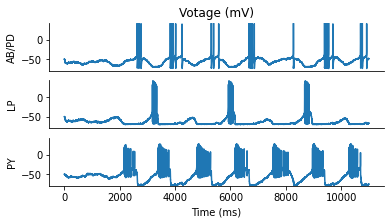

[      nan       nan 148.89375 169.3375        nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan   2.5       2.5    ]


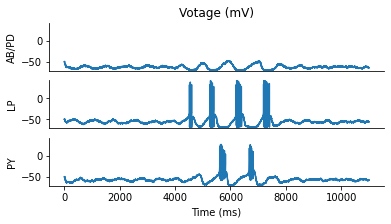

[2.02731667e+03 2.06493750e+02 1.71246429e+02 2.40985714e+02
 1.01855696e-01 8.44695017e-02 1.18869301e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


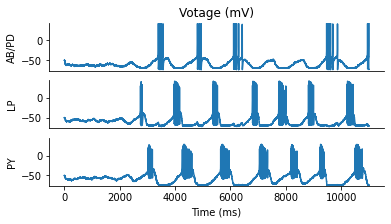

[1.89260625e+03 1.83270000e+02            nan 4.11725000e+02
 9.68347220e-02            nan 2.17543929e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
            nan 2.50000000e+00]


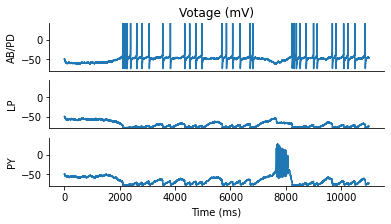

[2.09693750e+03 2.24925000e+02 1.68400000e+02 2.22120000e+02
 1.07263569e-01 8.03075914e-02 1.05925904e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


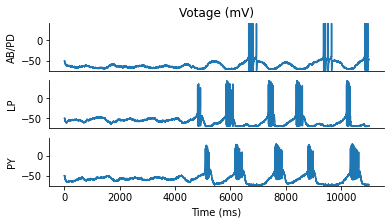

[1.34678929e+03 2.22443750e+02 2.25628571e+02 3.52721875e+02
 1.65165963e-01 1.67530715e-01 2.61898338e-01 4.41345952e-01
 6.38515941e-01 5.94400000e+02 2.65546429e+02 3.55289286e+02
 3.99178571e+01 2.63804657e-01 2.96392744e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


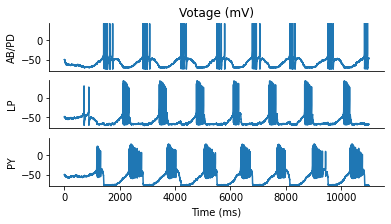

[2.05845625e+03 1.46710000e+02 1.79675000e+02 4.23015000e+02
 7.12718572e-02 8.72862855e-02 2.05501088e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


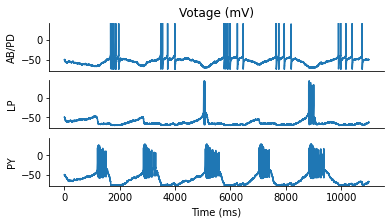

[1.49417500e+03 1.67010714e+02 1.50415625e+02 3.71418750e+02
 1.11774534e-01 1.00668011e-01 2.48577810e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


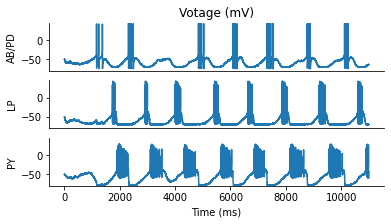

[         nan  97.675      147.284375   140.54166667          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
   2.5          2.5          2.5       ]


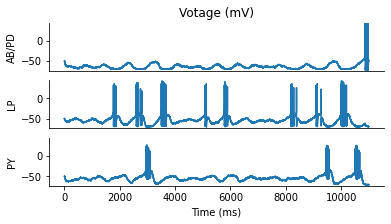

[         nan 256.525      232.425      221.92777778          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
   2.5          2.5          2.5       ]


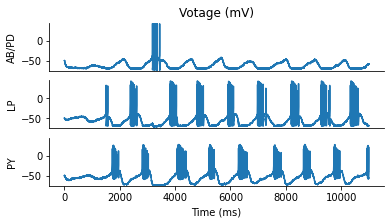

[    nan     nan 189.925 237.85      nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan   2.5     2.5  ]


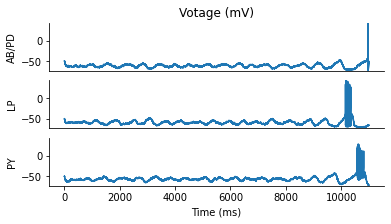

[6.06817500e+03 2.45762500e+02 2.20609375e+02 2.90118750e+02
 4.05002328e-02 3.63551438e-02 4.78098852e-02            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


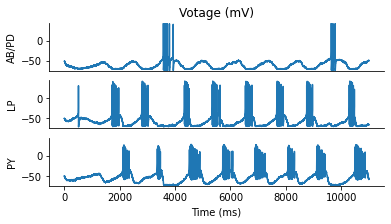

[   nan 104.55    nan 219.85    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan   2.5     nan   2.5 ]


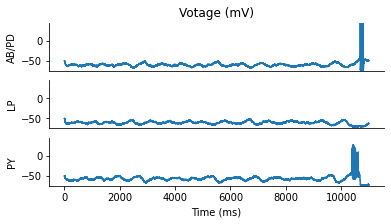

[1.78354000e+03 2.43808333e+02 2.30887500e+02 3.72483333e+02
 1.36699112e-01 1.29454624e-01 2.08844956e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


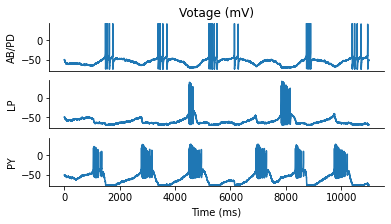

[1.39248000e+03 1.64141667e+02 1.21975000e+02 4.19825000e+02
 1.17877217e-01 8.75955130e-02 3.01494456e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


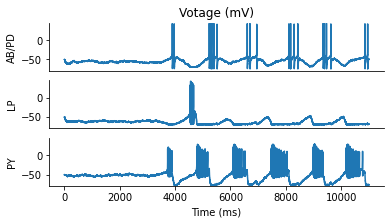

[1.51978333e+03 2.23178571e+02 1.19685000e+02 4.27441667e+02
 1.46848940e-01 7.87513571e-02 2.81251714e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


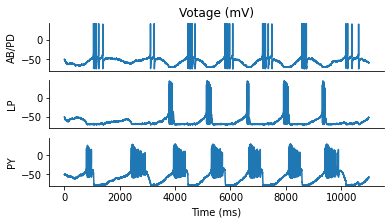

[1.96965833e+03 1.31243750e+02            nan 3.26083333e+02
 6.66327493e-02            nan 1.65553247e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
            nan 2.50000000e+00]


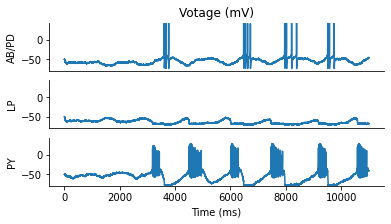

[1.92418750e+03 1.46685000e+02 1.69968750e+02 3.86139286e+02
 7.62321759e-02 8.83327378e-02 2.00676538e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


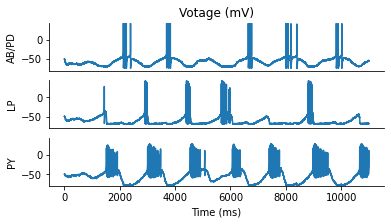

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


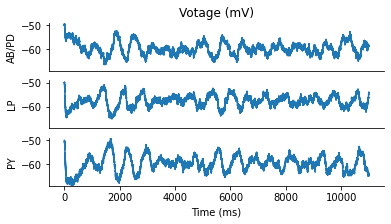

[2.02616250e+03 2.44350000e+02 2.38578571e+02 3.05721875e+02
 1.20597435e-01 1.17748982e-01 1.50887145e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


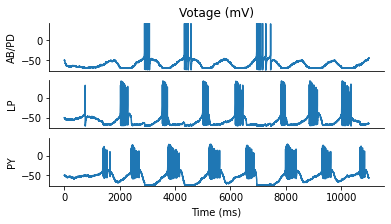

[1.75489000e+03 2.76641667e+02 2.03695833e+02 2.28060714e+02
 1.57640460e-01 1.16073277e-01 1.29957270e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


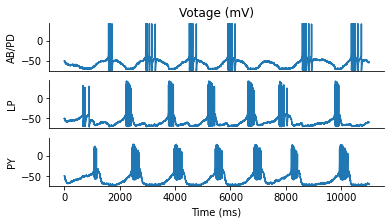

[1.89039500e+03 2.06325000e+02 1.14441667e+02 2.90408333e+02
 1.09143856e-01 6.05384942e-02 1.53623096e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


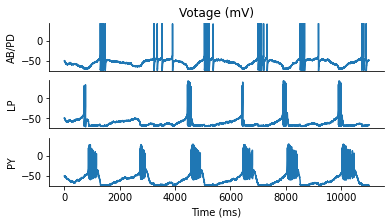

[1.94188333e+03 1.79175000e+02 1.54650000e+02 4.07141667e+02
 9.22686739e-02 7.96391819e-02 2.09663299e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


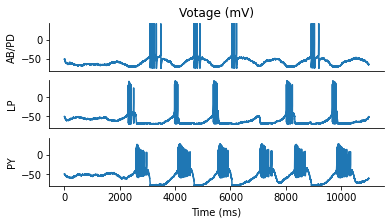

[1.83741667e+03 2.38837500e+02 1.16841667e+02 2.88315000e+02
 1.29985487e-01 6.35901855e-02 1.56913239e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


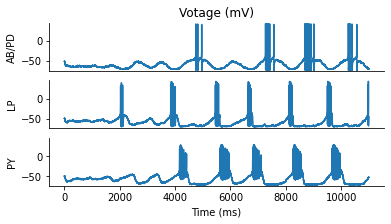

[1.59637000e+03 1.97579167e+02 1.32070000e+02 4.11300000e+02
 1.23767777e-01 8.27314470e-02 2.57647037e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


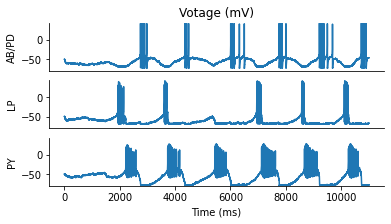

[2.13664375e+03 2.40950000e+02 2.40162500e+02 2.57225000e+02
 1.12770320e-01 1.12401752e-01 1.20387407e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


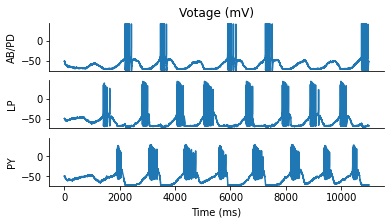

[1.25500000e+03 1.36825000e+02 1.57400000e+02 2.21825000e+02
 1.09023904e-01 1.25418327e-01 1.76752988e-01 4.20956175e-01
 6.09003984e-01 5.28300000e+02 2.36000000e+02 3.59950000e+02
 6.18500000e+01 2.86812749e-01 4.92828685e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


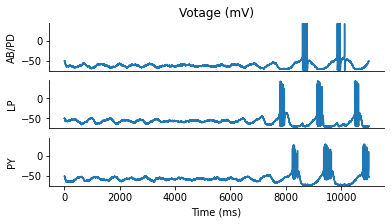

[1.64286875e+03 2.26370000e+02 2.11210714e+02 3.04907143e+02
 1.37789461e-01 1.28562135e-01 1.85594341e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


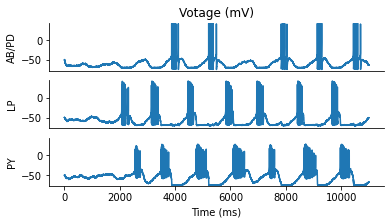

[1.33174167e+03 2.11812500e+02 2.18996429e+02 2.74581250e+02
 1.59049240e-01 1.64443626e-01 2.06182067e-01 4.36302086e-01
 6.51702970e-01 5.81041667e+02 2.86858333e+02 3.49741667e+02
 7.01166667e+01 2.62619752e-01 5.26503514e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


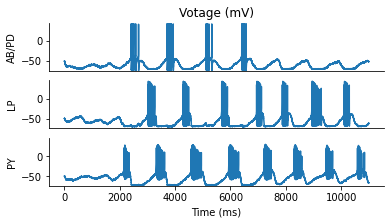

[1.41444500e+03 1.28270833e+02 1.27790000e+02 4.00132143e+02
 9.06863352e-02 9.03463903e-02 2.82889856e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


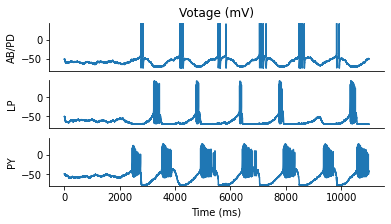

[1.29680000e+03 2.30735000e+02 2.13046429e+02 2.19684375e+02
 1.77926434e-01 1.64286265e-01 1.69404978e-01 4.55520319e-01
 6.67253046e-01 5.90718750e+02 2.74575000e+02 3.63112500e+02
 7.18312500e+01 2.80006555e-01 5.53911552e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


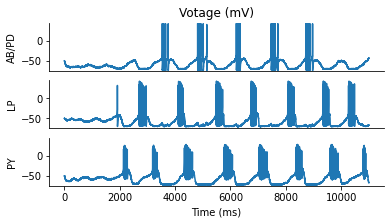

[1.46004167e+03 2.14182143e+02 1.25408333e+02 3.80685714e+02
 1.46695911e-01 8.58936674e-02 2.60736199e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


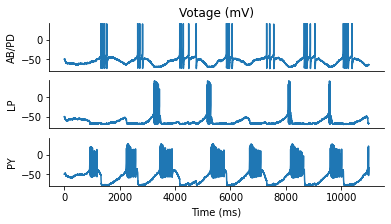

[1.47953750e+03 1.59365000e+02 9.64187500e+01 3.68091667e+02
 1.07712714e-01 6.51681691e-02 2.48788332e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


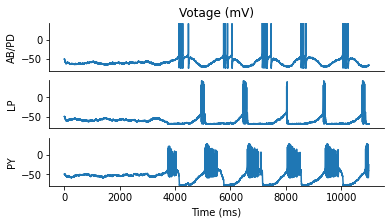

[1.44655000e+03 2.84825000e+02 2.07385000e+02 2.45550000e+02
 1.96899520e-01 1.43365248e-01 1.69748712e-01 5.16833155e-01
 6.68037745e-01 7.47625000e+02 2.18725000e+02 3.59150000e+02
 3.85250000e+01 2.48280391e-01 2.66323321e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


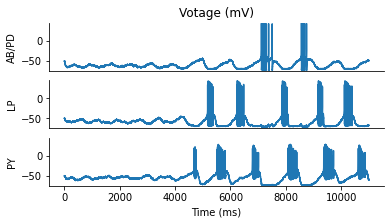

[1.68118500e+03 2.07437500e+02 1.65525000e+02 3.30867857e+02
 1.23387670e-01 9.84573381e-02 1.96806334e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


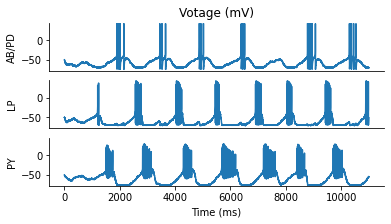

[2.38580000e+03 2.36300000e+02 1.71292857e+02 2.61460000e+02
 9.90443457e-02 7.17968217e-02 1.09590075e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


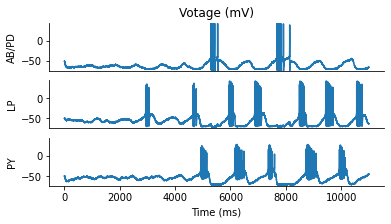

[1.50478750e+03 1.74925000e+02 1.75465625e+02 3.24962500e+02
 1.16245649e-01 1.16604919e-01 2.15952419e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


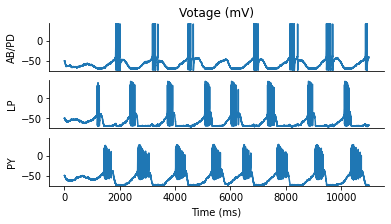

[         nan 273.875      175.659375   259.33333333          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
   2.5          2.5          2.5       ]


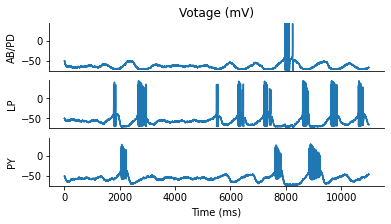

[1.68871500e+03 2.93154167e+02 1.50196429e+02 4.54793750e+02
 1.73595999e-01 8.89412533e-02 2.69313502e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


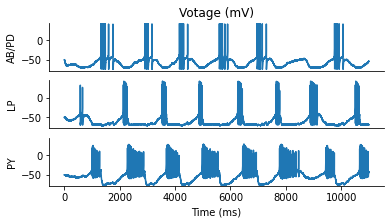

[1.51902917e+03 3.39796429e+02 1.85285000e+02 3.90800000e+02
 2.23693156e-01 1.21975933e-01 2.57269583e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


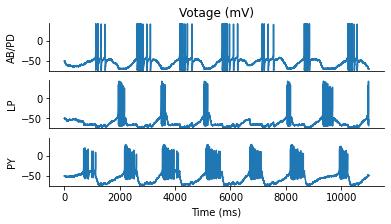

[     nan      nan 235.5    191.2875      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
   2.5      2.5   ]


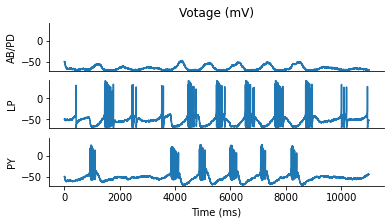

[    nan     nan 189.875     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan   2.5       nan]


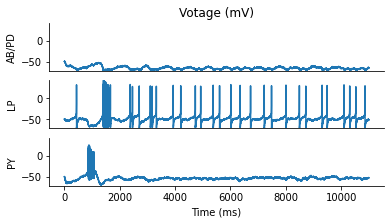

[1.28007500e+03 2.25685714e+02 1.45987500e+02 3.32700000e+02
 1.76306634e-01 1.14046052e-01 2.59906646e-01 4.76830785e-01
 6.55882793e-01 6.10379167e+02 2.29200000e+02 3.87233333e+02
 8.32125000e+01 3.02508317e-01 6.50059567e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


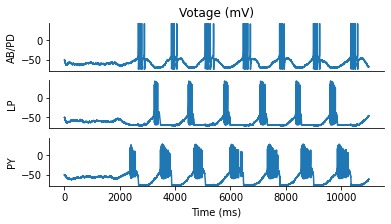

[2.11837500e+03 2.52631250e+02 1.68985714e+02 2.36091667e+02
 1.19257096e-01 7.97713881e-02 1.11449421e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


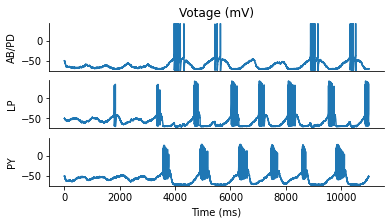

[1.64620500e+03 1.94895833e+02 2.07817857e+02 4.17993750e+02
 1.18390986e-01 1.26240570e-01 2.53913547e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


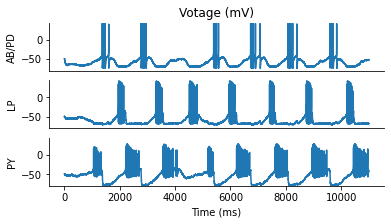

[2.42189167e+03 2.06837500e+02 1.90382143e+02 2.54507143e+02
 8.54032832e-02 7.86088600e-02 1.05086097e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


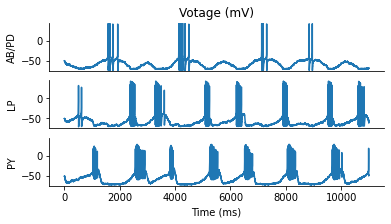

[2.40425000e+03 2.47662500e+02 2.60655556e+02 2.20272222e+02
 1.03010294e-01 1.08414497e-01 9.16178526e-02            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


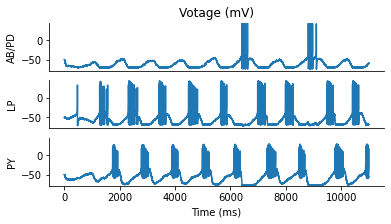

[1.34127083e+03 2.06550000e+02 1.66803571e+02 2.96421875e+02
 1.53995744e-01 1.24362334e-01 2.21000761e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]


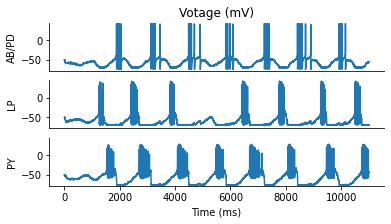

In [90]:
for s, d in zip(stats.to_numpy(), data):
    print(s[:18])
    show_traces(d)
    plt.show()

# For the 7 best performing circuits of each model separately, find two that differ really strongly in their parameters

### AB/PD

In [36]:
quantile = 0.0005

In [37]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

summed_energies = x['energies'].to_numpy()[:, 0] / 10 / 1000

In [38]:
inds = np.argsort(summed_energies)
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
one_percent_quantile = int(num_vals * quantile)
ninenine_percent_quantile = int(num_vals * (1-quantile))
one_percent_energy = sorted_energies[one_percent_quantile]
ninenine_percent_energy = sorted_energies[ninenine_percent_quantile]

min_energy_condition = summed_energies < one_percent_energy
min_energy_theta_abpd = theta_np[min_energy_condition]
min_energy_seed_abpd = seeds[min_energy_condition]
min_energy_energies = summed_energies[min_energy_condition]

0


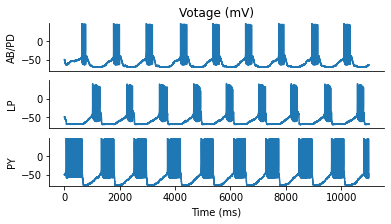

1


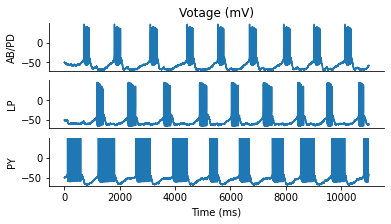

2


KeyboardInterrupt: 

In [29]:
counter = 0
for see, t in zip(min_energy_seed_abpd, min_energy_theta_abpd):
    print(counter)
    circuit_params = np.asarray([t])
    theta_pd = pd.DataFrame(circuit_params, columns=theta.columns)
    out_target = simulate(
        theta_pd.loc[0], seed=int(see), track_energy=True, track_currents=True
    )
    show_traces(out_target)
    plt.show()
    counter += 1

In [39]:
selected_inds_ab = [1, 3, 7, 8, 16]

In [31]:
print(min_energy_theta_abpd[selected_inds_ab])

[[ 1.49156555e+02  5.44863939e+00  3.83331609e+00  5.09418869e+01
   6.39966249e+00  1.12447678e+02  2.60657677e-03  6.24679355e-03
   1.11846138e+02  5.26848316e-01  5.12901592e+00  3.20751610e+01
   6.58098555e+00  5.42621269e+01  2.42956448e-02  3.24322693e-02
   5.06085022e+02  7.19877625e+00  2.40903878e+00  4.75725441e+01
   2.56849313e+00  1.02024261e+02  2.21933536e-02  5.20474464e-03
  -1.13153811e+01 -1.19375792e+01 -1.11642818e+01 -1.46362190e+01
  -1.01787710e+01 -1.56177740e+01 -1.05284424e+01]
 [ 7.36559982e+01  1.66502225e+00  3.75348330e+00  4.09858513e+01
   5.88592482e+00  1.40139572e+02  1.60755478e-02  3.51842050e-03
   1.49987473e+02  7.21264005e-01  6.37059975e+00  5.31468048e+01
   4.00905752e+00  5.95642738e+01  4.83396500e-02  3.12402975e-02
   5.48166016e+02  8.98762703e+00  3.05642939e+00  3.05623932e+01
   1.20245002e-01  1.21613892e+02  5.45296408e-02  1.45625258e-02
  -9.45680618e+00 -1.22561979e+01 -1.36053638e+01 -8.72751141e+00
  -9.23343182e+00 -1.2554

In [40]:
selections_of_pairs_ab = [[], []]

### LP

In [40]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

summed_energies = x['energies'].to_numpy()[:, 1] / 10 / 1000

In [41]:
inds = np.argsort(summed_energies)
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
one_percent_quantile = int(num_vals * quantile)
ninenine_percent_quantile = int(num_vals * (1-quantile))
one_percent_energy = sorted_energies[one_percent_quantile]
ninenine_percent_energy = sorted_energies[ninenine_percent_quantile]

min_energy_condition = summed_energies < one_percent_energy
min_energy_theta_lp = theta_np[min_energy_condition]
min_energy_seed_lp = seeds[min_energy_condition]
min_energy_energies = summed_energies[min_energy_condition]

0


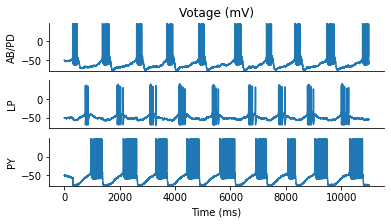

1


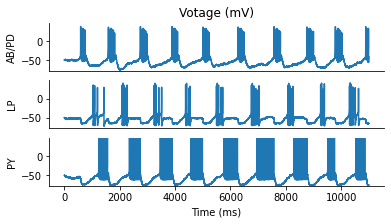

2


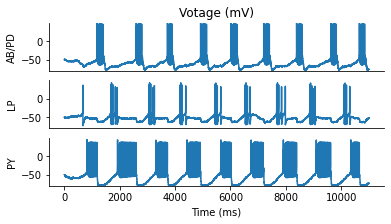

3


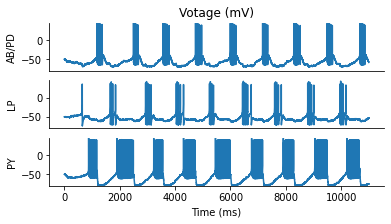

4


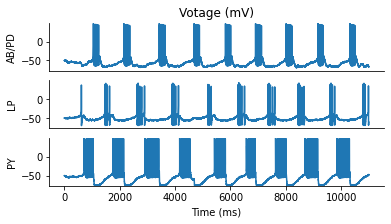

5


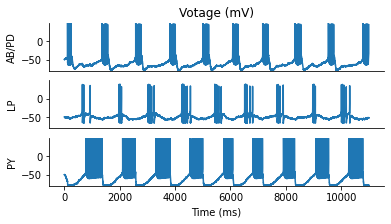

6


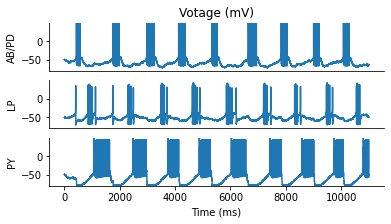

7


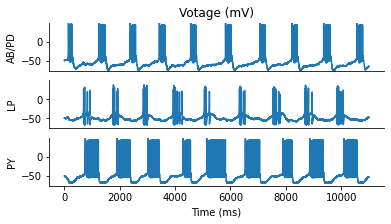

8


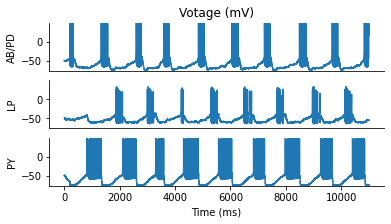

9


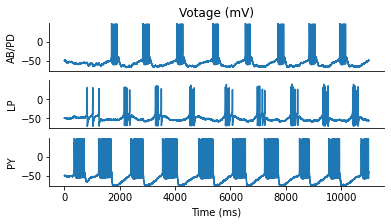

10


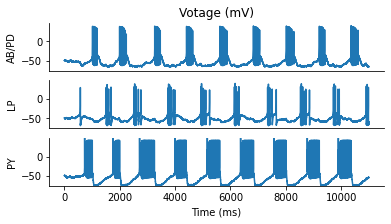

11


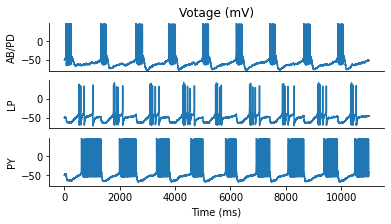

12


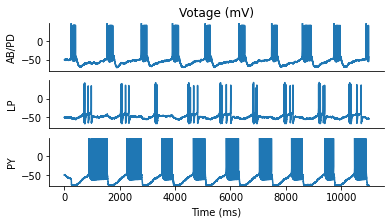

13


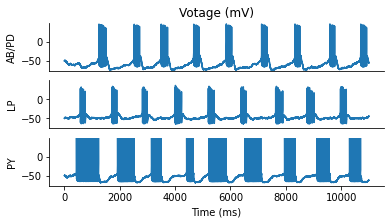

14


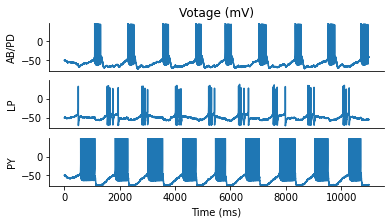

15


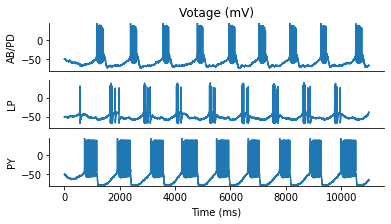

16


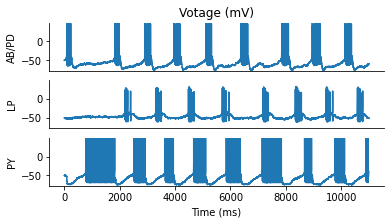

In [78]:
counter = 0
for see, t in zip(min_energy_seed_lp, min_energy_theta_lp):
    print(counter)
    circuit_params = np.asarray([t])
    theta_pd = pd.DataFrame(circuit_params, columns=theta.columns)
    out_target = simulate(
        theta_pd.loc[0], seed=int(see), track_energy=True, track_currents=True
    )
    show_traces(out_target)
    plt.show()
    counter += 1

In [42]:
selected_inds_lp = [0, 3, 4, 7, 13]

In [117]:
print(min_energy_theta_lp[selected_inds_lp])

[[ 1.52708740e+02  2.22049737e+00  3.99024534e+00  4.34835548e+01
   8.19415474e+00  1.25559837e+02  8.96100048e-03  6.38053194e-03
   1.01481537e+02  1.73716158e-01  4.35517311e+00  2.22715530e+01
   4.02582979e+00  1.12953568e+02  5.26913034e-04  2.94147730e-02
   1.51010788e+02  4.91377544e+00  3.48740935e+00  4.28421211e+01
   1.16394210e+00  1.45450867e+02  3.54221314e-02  5.74464630e-03
  -1.07017183e+01 -1.34841747e+01 -1.65442181e+01 -9.14491844e+00
  -9.54493713e+00 -1.59646845e+01 -1.12998371e+01]
 [ 1.47722656e+02  1.32396650e+00  5.58756208e+00  2.99488487e+01
   1.33870306e+01  1.00469612e+02  1.16835115e-02  9.09477123e-04
   6.30361023e+01  6.10251546e-01  2.37208033e+00  1.54200802e+01
   2.96495414e+00  6.21386642e+01  2.75140554e-02  2.32308321e-02
   5.78137451e+02  5.65867805e+00  3.99516511e+00  5.07125053e+01
   2.07887506e+00  1.19702797e+02  3.34463082e-02  3.86753157e-02
  -1.66160927e+01 -1.39890337e+01 -8.93908310e+00 -1.35682077e+01
  -1.06963558e+01 -1.2205

In [43]:
selections_of_pairs_lp = [[], []]

### PY

In [44]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

summed_energies = x['energies'].to_numpy()[:, 2] / 10 / 1000

In [45]:
inds = np.argsort(summed_energies)
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
one_percent_quantile = int(num_vals * quantile)
ninenine_percent_quantile = int(num_vals * (1-quantile))
one_percent_energy = sorted_energies[one_percent_quantile]
ninenine_percent_energy = sorted_energies[ninenine_percent_quantile]

min_energy_condition = summed_energies < one_percent_energy
min_energy_theta_py = theta_np[min_energy_condition]
min_energy_seed_py = seeds[min_energy_condition]
min_energy_energies = summed_energies[min_energy_condition]

0


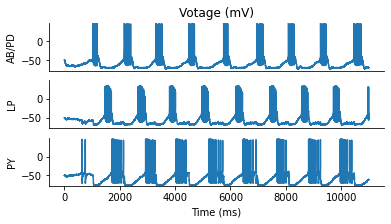

1


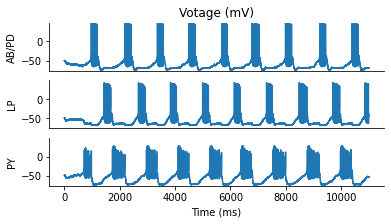

2


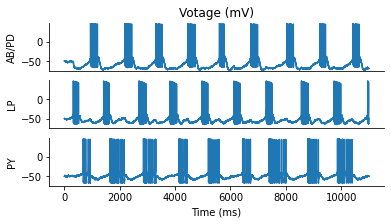

3


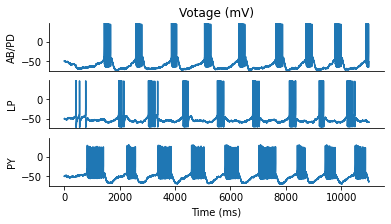

4


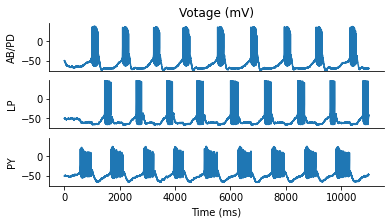

5


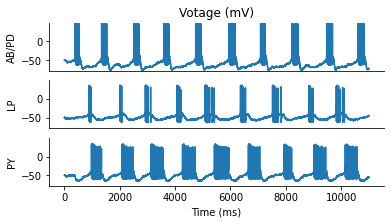

6


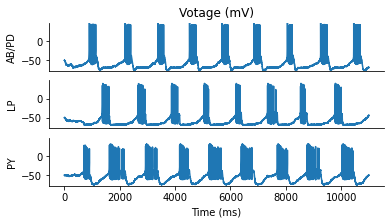

7


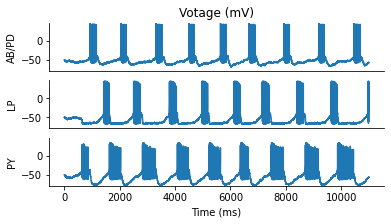

8


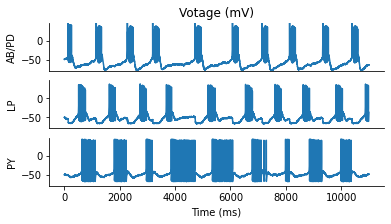

9


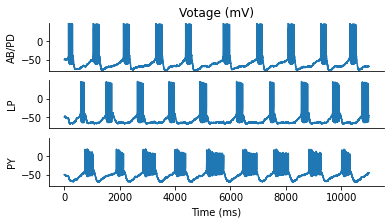

10


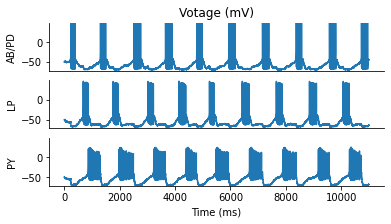

11


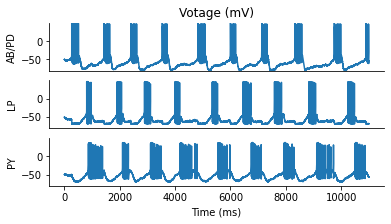

12


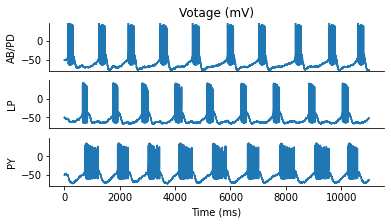

13


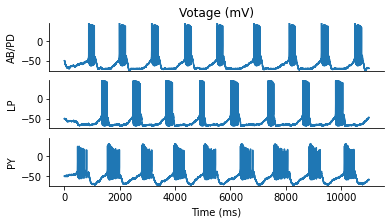

14


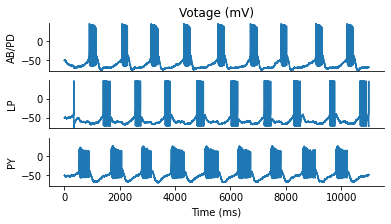

15


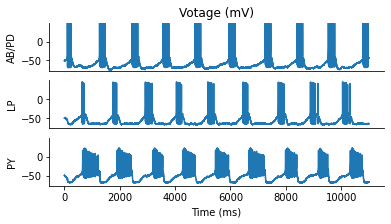

16


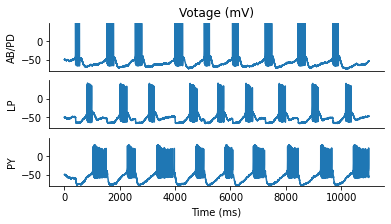

In [125]:
counter = 0
for see, t in zip(min_energy_seed_py, min_energy_theta_py):
    print(counter)
    circuit_params = np.asarray([t])
    theta_pd = pd.DataFrame(circuit_params, columns=theta.columns)
    out_target = simulate(
        theta_pd.loc[0], seed=int(see), track_energy=True, track_currents=True
    )
    show_traces(out_target)
    plt.show()
    counter += 1

In [46]:
selected_inds_py = [0, 1, 5, 12]

In [127]:
print(min_energy_theta_py[selected_inds_py])

[[ 3.78879303e+02  3.00276637e+00  7.13621330e+00  5.73724289e+01
   1.36615763e+01  7.19413986e+01  2.20571319e-03  7.94659648e-03
   7.06633072e+01  1.66540897e+00  3.46431279e+00  2.27729702e+01
   5.78854275e+00  9.64088516e+01  4.68371995e-02  2.53961366e-02
   1.65442947e+02  7.57918775e-01  3.60276437e+00  3.30752296e+01
   1.56747907e-01  1.20564339e+02  1.09396391e-02  1.68930236e-02
  -8.84261131e+00 -1.62734032e+01 -1.64058266e+01 -9.48571968e+00
  -7.52465057e+00 -1.66985226e+01 -9.33200932e+00]
 [ 2.62294098e+02  3.48991609e+00  3.54513311e+00  1.65248718e+01
   1.06084995e+01  1.11894539e+02  6.78709708e-03  2.68222811e-03
   1.34923904e+02  2.19589090e+00  5.05914736e+00  4.20894585e+01
   7.63766861e+00  1.11393471e+02  5.44256903e-02  3.50575782e-02
   4.42253571e+01  1.06298733e+00  2.03898287e+00  3.39868202e+01
   3.34089220e-01  6.15611687e+01  3.73839363e-02  3.05260345e-03
  -8.02914906e+00 -1.77260017e+01 -1.02758999e+01 -1.06674604e+01
  -8.71595955e+00 -1.6062

In [47]:
selections_of_pairs_py = [[], []]

### Run all combinations...

In [48]:
xo

array([1.17085859e+03, 2.06036434e+02, 2.14307031e+02, 4.12842187e+02,
       1.75970382e-01, 1.83034085e-01, 3.52597820e-01, 4.11600328e-01,
       6.30544893e-01, 4.81925781e+02, 2.56353125e+02, 2.75164844e+02,
       4.20460938e+01, 2.35011166e-01, 3.59104797e-02, 2.50000000e+00,
       2.50000000e+00, 2.50000000e+00])

=== Running pair 1 0 0 ===


  0%|          | 0/2800 [00:00<?, ?it/s]

Generating MCMC samples


100%|██████████| 2800/2800 [06:55<00:00,  6.74it/s]


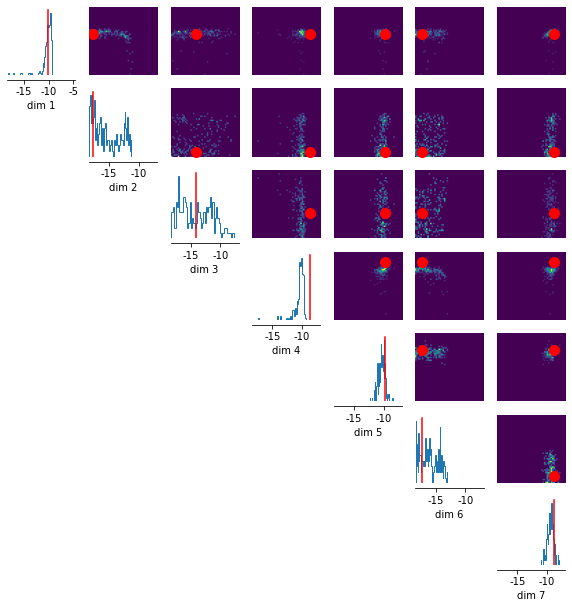

=== Running pair 1 0 1 ===


  0%|          | 0/2800 [00:00<?, ?it/s]

Generating MCMC samples


100%|██████████| 2800/2800 [07:24<00:00,  6.30it/s]


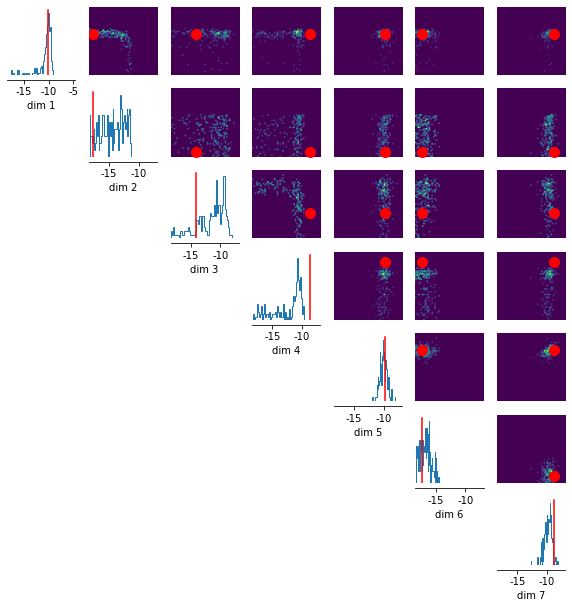

=== Running pair 1 0 5 ===


  0%|          | 0/2800 [00:00<?, ?it/s]

Generating MCMC samples


100%|██████████| 2800/2800 [06:50<00:00,  6.82it/s]


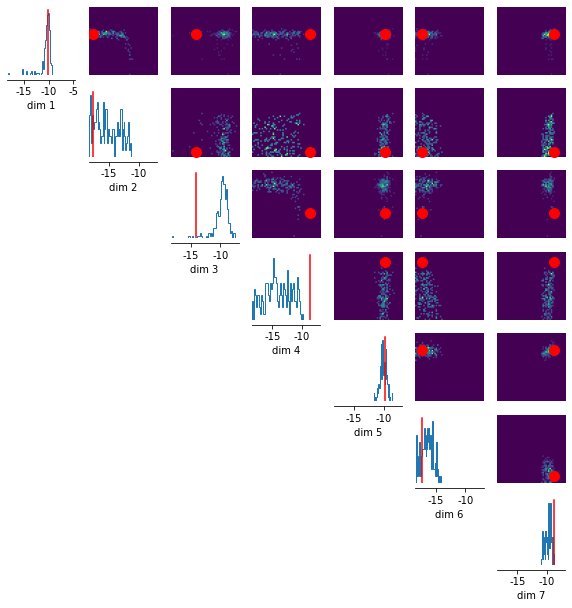

=== Running pair 1 0 12 ===


  0%|          | 0/2800 [00:00<?, ?it/s]

Generating MCMC samples


100%|██████████| 2800/2800 [07:26<00:00,  6.27it/s]


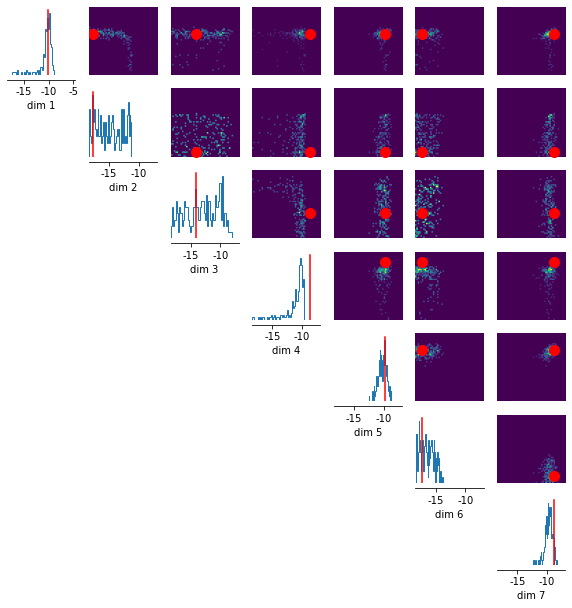

=== Running pair 1 3 0 ===


  0%|          | 0/2800 [00:00<?, ?it/s]

Generating MCMC samples


100%|██████████| 2800/2800 [07:05<00:00,  6.58it/s]


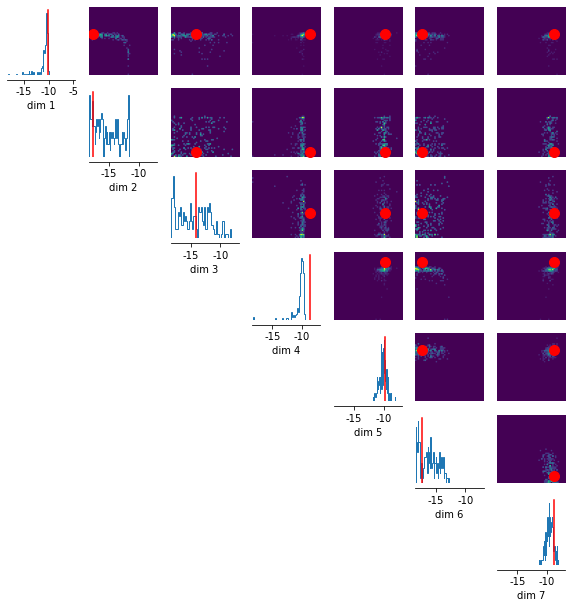

=== Running pair 1 3 1 ===


  0%|          | 0/2800 [00:00<?, ?it/s]

Generating MCMC samples


100%|██████████| 2800/2800 [07:08<00:00,  6.54it/s]


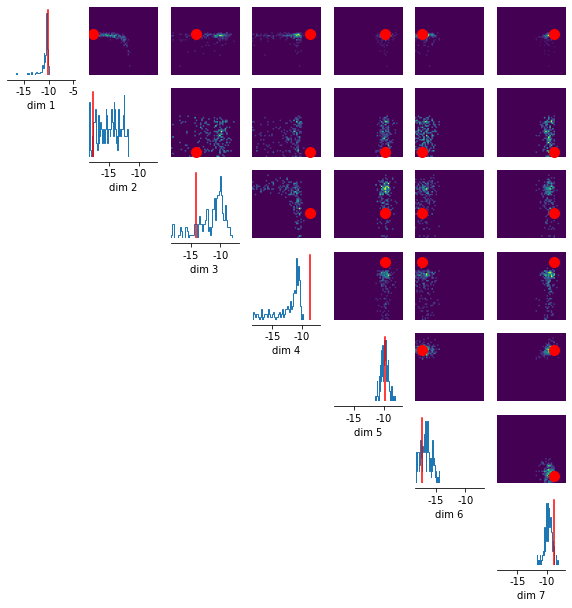

=== Running pair 1 3 5 ===


  0%|          | 0/2800 [00:00<?, ?it/s]

Generating MCMC samples


100%|██████████| 2800/2800 [07:00<00:00,  6.65it/s]


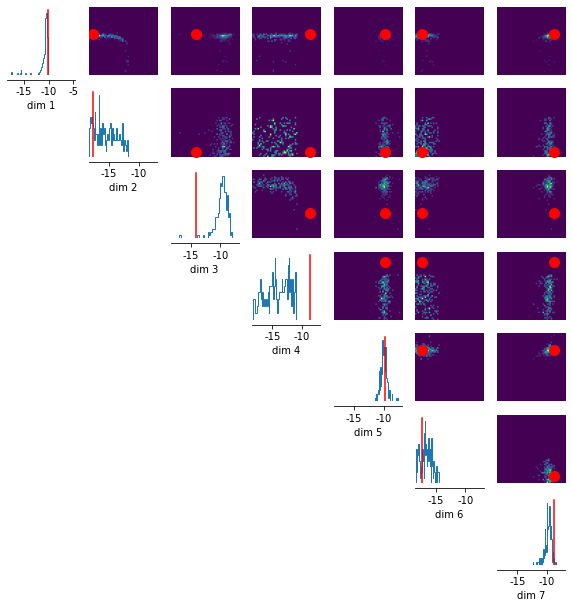

=== Running pair 1 3 12 ===


  0%|          | 0/2800 [00:00<?, ?it/s]

Generating MCMC samples


100%|██████████| 2800/2800 [07:10<00:00,  6.50it/s]


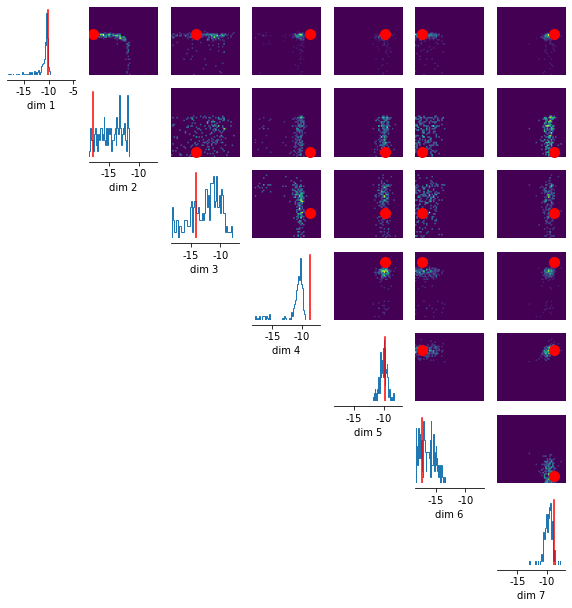

=== Running pair 1 4 0 ===


  0%|          | 0/2800 [00:00<?, ?it/s]

Generating MCMC samples


100%|██████████| 2800/2800 [07:28<00:00,  6.25it/s]


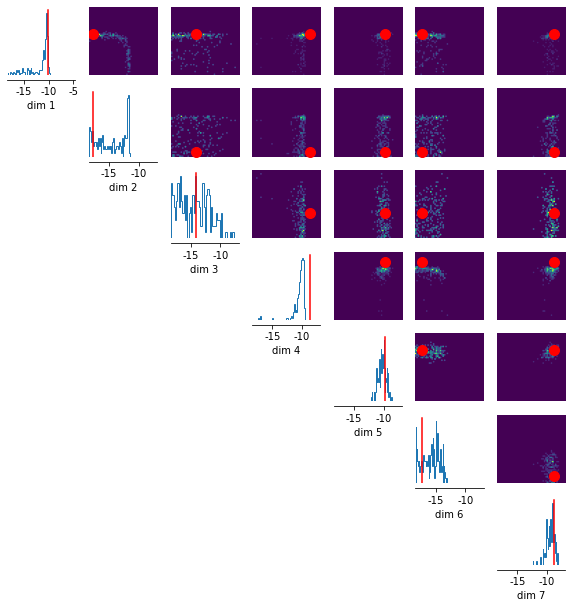

=== Running pair 1 4 1 ===


  0%|          | 0/2800 [00:00<?, ?it/s]

Generating MCMC samples


100%|██████████| 2800/2800 [07:24<00:00,  6.30it/s]


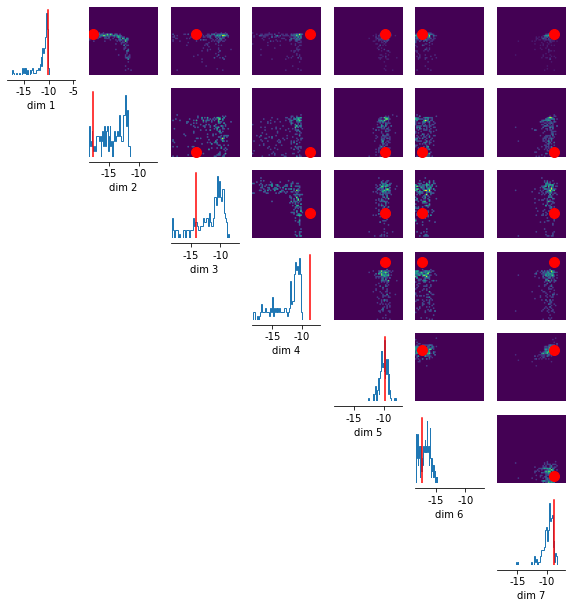

=== Running pair 1 4 5 ===


  0%|          | 0/2800 [00:00<?, ?it/s]

Generating MCMC samples


100%|██████████| 2800/2800 [07:13<00:00,  6.46it/s]


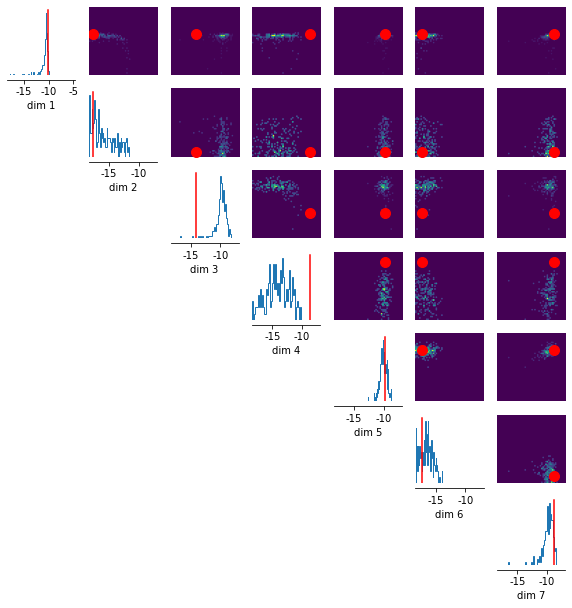

=== Running pair 1 4 12 ===


  0%|          | 0/2800 [00:00<?, ?it/s]

Generating MCMC samples


100%|██████████| 2800/2800 [07:34<00:00,  6.16it/s]


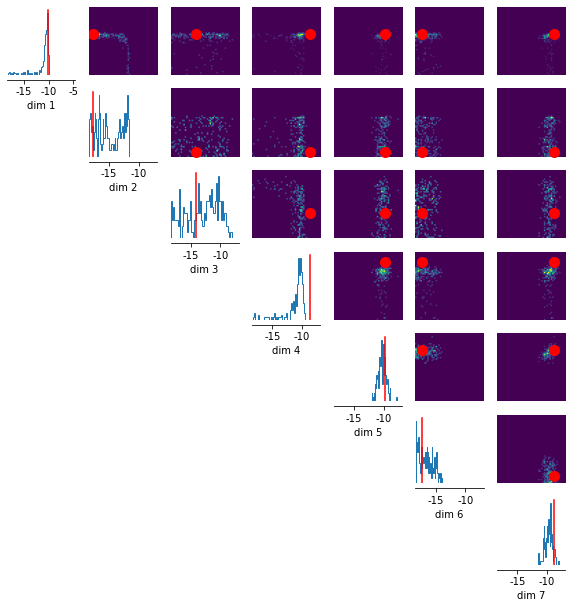

=== Running pair 1 7 0 ===


  0%|          | 0/2800 [00:00<?, ?it/s]

Generating MCMC samples


100%|██████████| 2800/2800 [07:56<00:00,  5.88it/s]


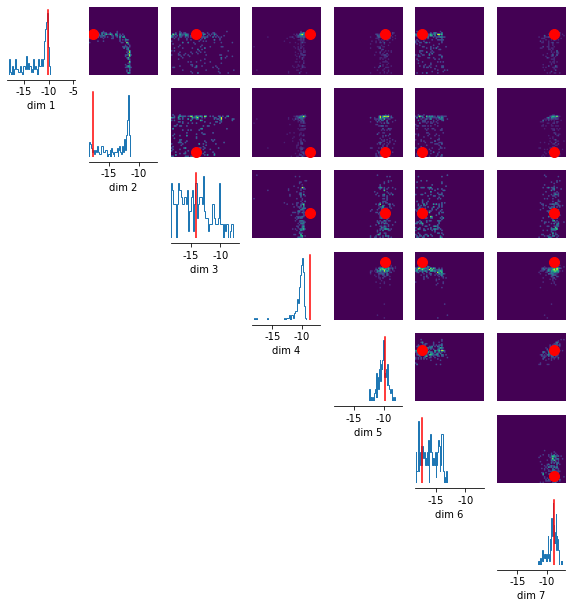

=== Running pair 1 7 1 ===


  0%|          | 0/2800 [00:00<?, ?it/s]

Generating MCMC samples


100%|██████████| 2800/2800 [07:20<00:00,  6.36it/s]


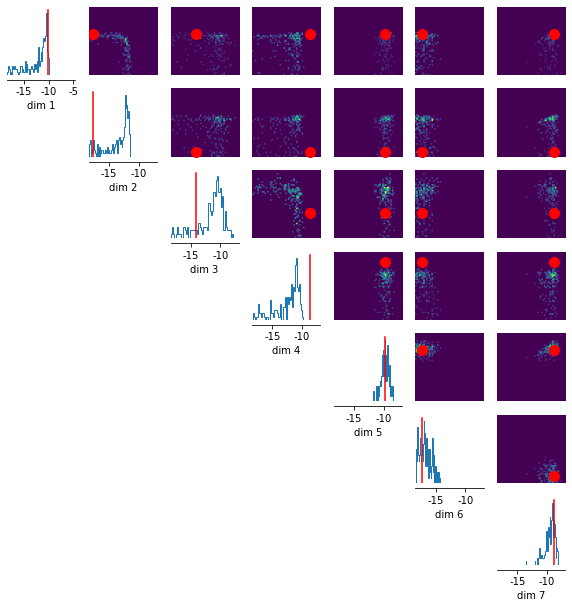

=== Running pair 1 7 5 ===


  0%|          | 0/2800 [00:00<?, ?it/s]

Generating MCMC samples


100%|██████████| 2800/2800 [07:12<00:00,  6.48it/s]


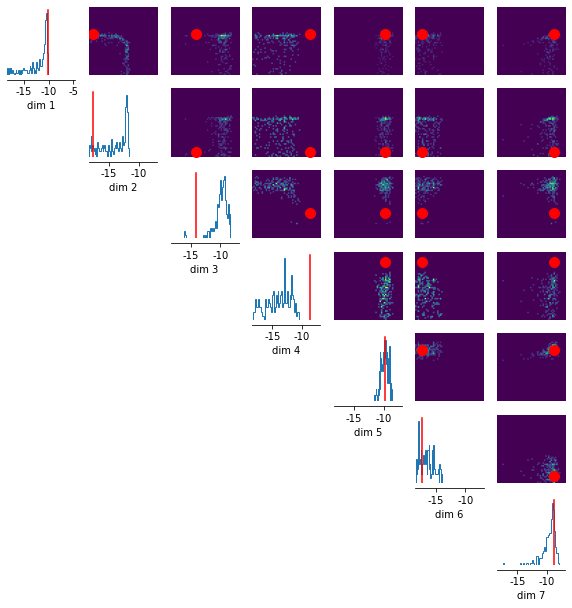

=== Running pair 1 7 12 ===


  0%|          | 0/2800 [00:00<?, ?it/s]

Generating MCMC samples


100%|██████████| 2800/2800 [07:24<00:00,  6.30it/s]


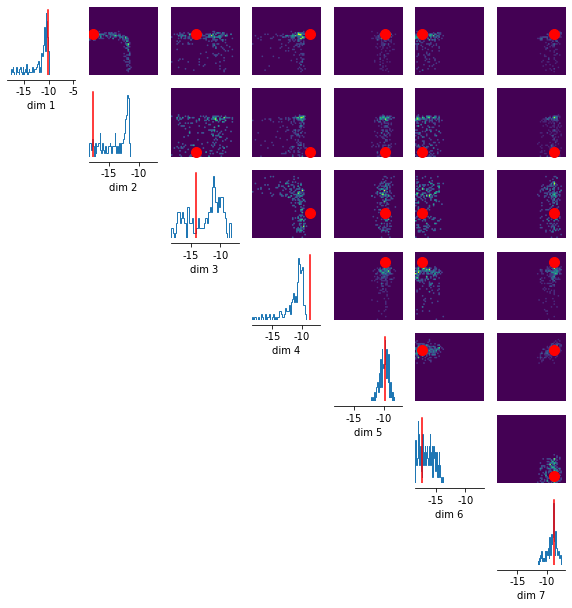

=== Running pair 1 13 0 ===


  0%|          | 0/2800 [00:00<?, ?it/s]

Generating MCMC samples


100%|██████████| 2800/2800 [07:22<00:00,  6.33it/s]


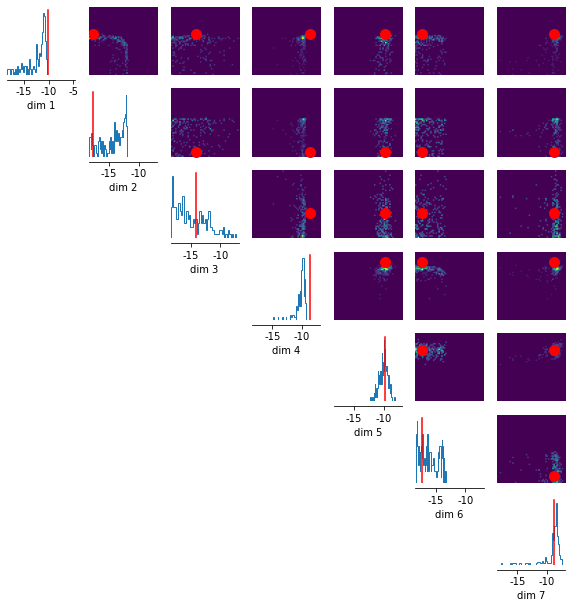

=== Running pair 1 13 1 ===


  0%|          | 0/2800 [00:00<?, ?it/s]

Generating MCMC samples


100%|██████████| 2800/2800 [07:09<00:00,  6.51it/s]


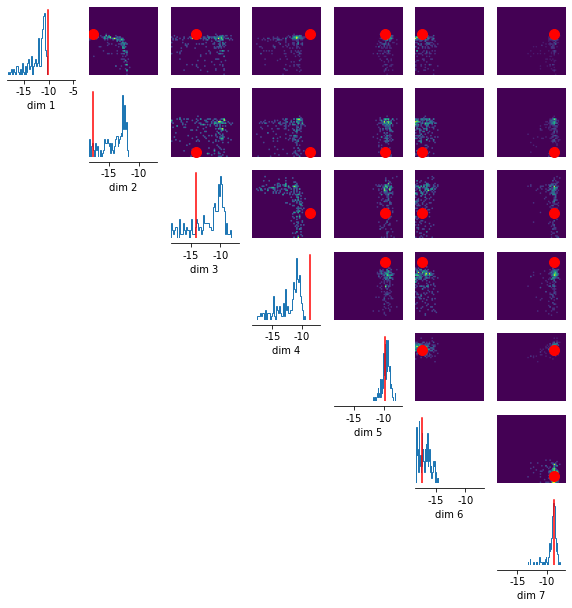

=== Running pair 1 13 5 ===


  0%|          | 0/2800 [00:00<?, ?it/s]

Generating MCMC samples


100%|██████████| 2800/2800 [07:08<00:00,  6.53it/s]


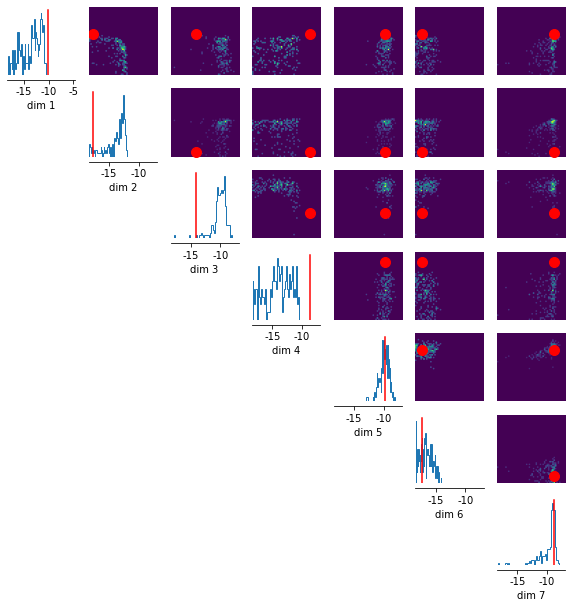

=== Running pair 1 13 12 ===


  0%|          | 0/2800 [00:00<?, ?it/s]

Generating MCMC samples


100%|██████████| 2800/2800 [07:15<00:00,  6.44it/s]


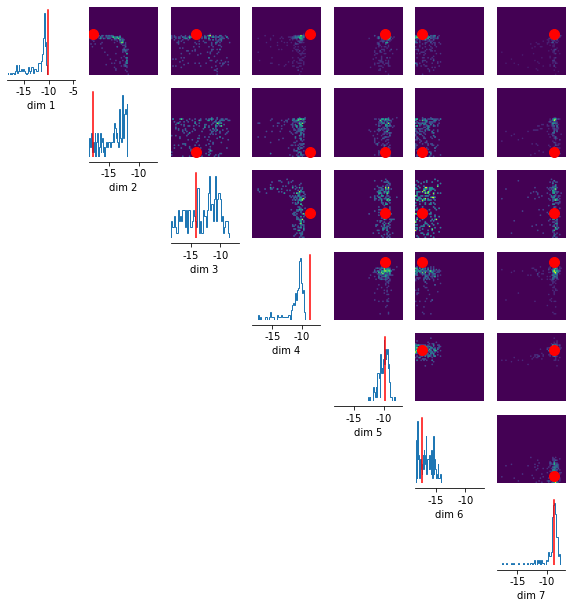

=== Running pair 3 0 0 ===


  0%|          | 0/2800 [00:00<?, ?it/s]

Generating MCMC samples


 62%|██████▏   | 1730/2800 [04:20<01:49,  9.80it/s]

In [ ]:
num_sims = 200

for pair_ab in selected_inds_ab:
    for pair_lp in selected_inds_lp:
        for pair_py in selected_inds_py:
            _ = torch.manual_seed(0)
            np.random.seed(0)
            print("=== Running pair", pair_ab, pair_lp, pair_py, "===")
            optimal_1 = min_energy_theta_abpd[0]
            dims_to_sample = [24,25,26,27,28,29,30]
            optimal_1[8:16] = min_energy_theta_lp[pair_lp, 8:16]
            optimal_1[16:24] = min_energy_theta_py[pair_py, 16:24]
            optimal_1 = torch.as_tensor(optimal_1, dtype=torch.float32)
            samples = posterior.sample_conditional(
                (num_sims,), 
                condition=torch.as_tensor(optimal_1, dtype=torch.float32),
                dims_to_sample=dims_to_sample, 
                x=xo,
                mcmc_method="slice_np_vectorized",
                mcmc_parameters={"init_strategy": "sir", "num_chains": 4},
            )
            _ = pairplot(samples, limits=limits[dims_to_sample], points=min_energy_theta_abpd[0][dims_to_sample], points_colors="r")
            plt.show()
            np.save(f"mcmc_samples_{pair_ab}_{pair_lp}_{pair_py}.npy", samples)

### Simulate these samples

In [ ]:
for pair_ab in selected_inds_ab:
    for pair_lp in selected_inds_lp:
        for pair_py in selected_inds_py:
            samples = np.load(f"mcmc_samples_{pair_ab}_{pair_lp}_{pair_py}.npy")
            np.random.seed(0)
            num_cores = 24
            seeds_sim = np.random.randint(0, 10000, num_sims)

            extended_samples = optimal_1.unsqueeze(0).repeat(num_sims, 1)
            extended_samples[:, dims_to_sample] = samples

            params_with_seeds = np.concatenate(
                (
                    extended_samples.numpy()[:num_sims],
                    seeds_sim[None,].T,
                ),
                axis=1,
            )

            with Pool(num_cores) as pool:
                data = pool.map(simulator, params_with_seeds)

            custom_stats = {
                    "plateau_durations": True,
                    "num_bursts": True,
                    "num_spikes": True,
                    "energies": True,
                    "energies_per_burst": True,
                    "energies_per_spike": True,
                    "pyloric_like": True,
                }
            stats = [summary_stats(d, stats_customization=custom_stats, t_burn_in=1000) for d in data]
            stats = pd.concat(stats)
            
            stats.to_pickle(f"simulated_samples_{pair_ab}_{pair_lp}_{pair_py}.pkl")

            close_sim = check_if_close_to_obs(stats.to_numpy())
            print("Number of close sims:  ", np.sum(close_sim))

            close_sim = check_if_close_to_obs(stats.to_numpy(), sloppiness_durations=2.0, sloppiness_phases=2.0)
            print("Sloppi 2.0 number of close sims:  ", np.sum(close_sim))

            close_sim = check_if_close_to_obs(stats.to_numpy(), sloppiness_durations=3.0, sloppiness_phases=3.0)
            print("Sloppi 3.0 number of close sims:  ", np.sum(close_sim))

            close_sim = check_if_close_to_obs(stats.to_numpy(), sloppiness_durations=10.0, sloppiness_phases=10.0)
            print("Sloppi 10.0 number of close sims:  ", np.sum(close_sim))

            #             for s, d in zip(stats.to_numpy(), data):
            #                 print(s[:18])
            #                 show_traces(d)
            #                 plt.show()

### Simulate the best simulation for each scenario

In [ ]:
successful_samples_tt = []
for pair_ab in selected_inds_ab:
    for pair_lp in selected_inds_lp:
        for pair_py in selected_inds_py:
            samples = np.load(f"mcmc_samples_{pair_ab}_{pair_lp}_{pair_py}.npy")
            stats = pd.read_pickle(f"simulated_samples_{pair_ab}_{pair_lp}_{pair_py}.pkl")
            close_sim = check_if_close_to_obs(stats.to_numpy())
            
            successful_samples = samples[close_sim]
            successful_samples_tt.append(torch.as_tensor(successful_samples, torch.float32))
            print("posterior log_prob", posterior.log_prob(successful_samples_tt, x=xo))
            trace = simulator(np.concatenate((successful_samples[0], np.asarray([0]))))
            stats = summary_stats(trace, stats_customization=custom_stats, t_burn_in=1000)
            print(stats.to_numpy()[:18])
            print("Energy consumption", stats["energy"])
            show_traces(trace)
            plt.show()
successful_samples_tt = torch.stack(successful_samples_tt)

In [ ]:
selected_ones_1 = [1, 0, 0]
selected_ones_2 = [1, 0, 1]

### Plot a histogramm over posterior log-probs for later comparison

In [ ]:
samples = posterior.sample((1000,), x=xo)
log_probs = posterior.log_prob(samples, x=xo).numpy()
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.hist(log_probs, color="k")
    for success_samples_ in successful_samples_tt:
        ax.axvline(success_samples_, color="r")
    ax.set_xlabel("Posterior log-prob")
    ax.set_ylabel("Count")

# Generate final plot

In [ ]:
time_vec = np.arange(0, 11000, 0.025)

### Plot 2 traces

In [ ]:
def plot_stuff(selected_ones):
    samples = np.load(f"mcmc_samples_{selected_ones[0]}_{selected_ones[1]}_{selected_ones[2]}.npy")
    stats = pd.read_pickle(f"simulated_samples_{selected_ones[0]}_{selected_ones[1]}_{selected_ones[2]}.pkl")
    close_sim = check_if_close_to_obs(stats.to_numpy())

    successful_samples = samples[close_sim]
    trace = simulator(np.concatenate((successful_samples[0], np.asarray([0]))))
    stats = summary_stats(trace, stats_customization=custom_stats, t_burn_in=1000)
    print(stats.to_numpy()[:18])
    print("Energy consumption", stats["energy"])
    
    with mpl.rc_context(fname='../../../.matplotlibrc'):
        fig, ax = plt.subplots(1,1,figsize=(2.2,1.2))
        viz.vis_sample_plain(
            voltage_trace=trace,
            t=time_vec,
            axV=ax,
            time_len=int(time_len),
            offset=0,
            col="k",
            scale_bar=True,
            scale_bar_voltage=True,
            print_label=False,
        )

In [ ]:
plot_stuff(selected_ones_1)
plt.show()
plot_stuff(selected_ones_2)
plt.show()

### Plot the different parameters of the 2

In [ ]:
def plot_params(selected_ones, params_to_plot):
    samples = np.load(f"mcmc_samples_{selected_ones[0]}_{selected_ones[1]}_{selected_ones[2]}.npy")
    stats = pd.read_pickle(f"simulated_samples_{selected_ones[0]}_{selected_ones[1]}_{selected_ones[2]}.pkl")
    close_sim = check_if_close_to_obs(stats.to_numpy())
    
    successful_samples = samples[close_sim][0]

    with mpl.rc_context(fname='../../../.matplotlibrc'):
        fig, ax = plt.subplots(1, 1, figsize=(1, 1.))
        ax.bar(successful_samples[params_to_plot])
        ax.set_xlabel(labels_[params_to_plot])

In [ ]:
params_to_plot = [3, 14, 23, 26]

plot_params(selected_ones_1)
plt.show()
plot_params(selected_ones_2)
plt.show()

### Plot the energy bars for the 2 configurations

In [ ]:
def plot_energies(selected_ones_1, selected_ones_2):
    stats = pd.read_pickle(f"simulated_samples_{selected_ones_1[0]}_{selected_ones_1[1]}_{selected_ones_1[2]}.pkl")
    close_sim = check_if_close_to_obs(stats.to_numpy())
    successful_stats1 = stats[close_sim][0]
    
    stats = pd.read_pickle(f"simulated_samples_{selected_ones_2[0]}_{selected_ones_2[1]}_{selected_ones_2[2]}.pkl")
    close_sim = check_if_close_to_obs(stats.to_numpy())
    successful_stats2 = stats[close_sim][0]
    
    energy1 = successful_stats1["energies"].to_numpy()
    energy2 = successful_stats2["energies"].to_numpy()
    
    summed_energies_total1 = np.sum(np.asarray(energy1), axis=1)/10/1000
    summed_energies_total2 = np.sum(np.asarray(energy2), axis=1)/10/1000

    with mpl.rc_context(fname='../../../.matplotlibrc'):
        fig, ax = plt.subplots(1, 1, figsize=(1, 1.))
        ax.bar([summed_energies_total1, summed_energies_total2])
        ax.set_xlabel("Configuration")
        ax.set_ylabel("Energy consumpion")
        
    return summed_energies_total1, summed_energies_total2

In [ ]:
summed_energies_total1, summed_energies_total2 = plot_energies(selected_ones_1, selected_ones_2)

### Plot the histogram of where the energies end up

In [ ]:
theta = pd.read_pickle("../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl")
x = pd.read_pickle("../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl")
seeds = np.load("../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy")

theta_np = theta.to_numpy()
x_np = x.to_numpy()

all_total_energies = x["energies"].to_numpy()
summed_energies_total = np.sum(np.asarray(all_total_energies), axis=1)

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 1))
    _ = ax.hist(summed_energies_total/10/1000, range=[0, 30], bins=100, color="k")
    ax.axvline(summed_energies_total1, color="r")
    ax.axvline(summed_energies_total2, color="r")
    ax.set_ylabel('Count')
    ax.tick_params(axis="both", which="major")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.set_title("Energy")

### Code for debugging

In [58]:
num_sims = 1000

dims_to_sample = [24,25]

optimal_1 = min_energy_theta_abpd[0]
optimal_1 = torch.as_tensor(optimal_1, dtype=torch.float32)

samples = posterior.sample_conditional(
    (num_sims,), 
    condition=torch.as_tensor(optimal_1, dtype=torch.float32),
    dims_to_sample=dims_to_sample, 
    x=xo,
    mcmc_method="slice_np_vectorized",
    mcmc_parameters={"enable_transform": True, "init_strategy": "sir", "num_chains": 10},
)

  0%|          | 0/12000 [00:00<?, ?it/s]

Generating MCMC samples


100%|██████████| 12000/12000 [05:58<00:00,  2.81it/s]

100%|██████████| 12000/12000 [05:59<00:00, 33.34it/s]


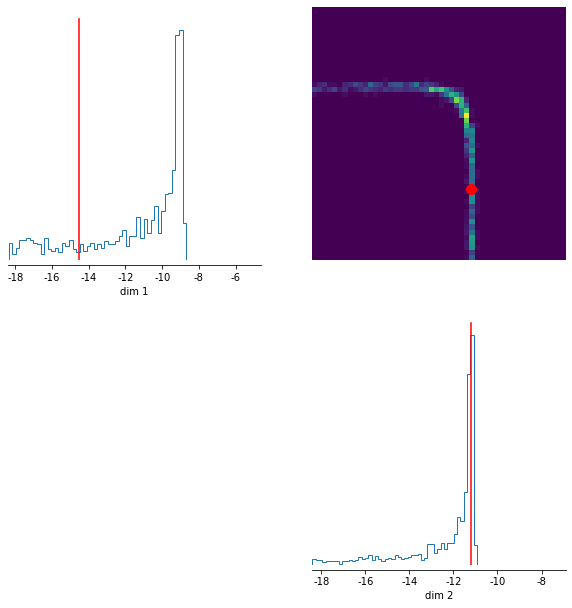

In [59]:
_ = pairplot(samples, limits=limits[dims_to_sample], points=min_energy_theta_abpd[0][dims_to_sample], points_colors="r")
plt.show()

### Run MCMC for the pairs and simulate them

In [ ]:
for pair_ab in selections_of_pairs_ab:
    for pair_lp in selections_of_pairs_lp:
        for pair_py in selections_of_pairs_py:
            print("=== Running pair", pair_ab, pair_lp, pair_py, "===")
            optimal_1 = min_energy_theta_ab[pair_ab[0]]
            optimal_1[8:16] = min_energy_theta_LP[pair_lp[0], 8:16]
            optimal_1[16:24] = min_energy_theta_PY[pair_py[0], 16:24]
            optimal_1 = torch.as_tensor(optimal_1, dtype=torch.float32)
            samples = posterior.sample_conditional(
                (1000,), 
                condition=torch.as_tensor(optimal_1, dtype=torch.float32),
                dims_to_sample=[24,25,26,27,28,29,30], 
                x=xo,
                mcmc_method="slice_np",
                mcmc_parameters={"init_strategy": "sir"},
            )
            traces = simulate(samples)
            stats = summary_stats(traces)
            close_sim = check_if_close_to_obs(stats)
            show_traces(close_sim)
            
            optimal_2 = min_energy_theta_ab[pair_ab[1]]
            optimal_2[8:16] = min_energy_theta_LP[pair_lp[1], 8:16]
            optimal_2[16:24] = min_energy_theta_PY[pair_py[1], 16:24]
            optimal_2 = torch.as_tensor(optimal_1, dtype=torch.float32)
            samples = posterior.sample_conditional(
                (1000,), 
                condition=torch.as_tensor(optimal_2, dtype=torch.float32),
                dims_to_sample=[24,25,26,27,28,29,30], 
                x=xo,
                mcmc_method="slice_np",
                mcmc_parameters={"init_strategy": "sir"},
            )
            traces = simulate(samples)
            stats = summary_stats(traces)
            close_sim = check_if_close_to_obs(stats)
            show_traces(close_sim)